## Project 5 - Vehicle Detection and Tracking

##### By Matthew Zimmer - Future Self-Driving Car Engineer

[GitHub](https://github.com/matthewzimmer) | [LinkedIn](https://www.linkedin.com/in/matthewazimmer)

---

**Vehicle Detection Project**

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.


## [Rubric](https://review.udacity.com/#!/rubrics/513/view) Points

### Here I will consider the rubric points individually and describe how I addressed each point in my implementation.

---

### Writeup / README

#### 1. Provide a Writeup / README that includes all the rubric points and how you addressed each one.  You can submit your writeup as markdown or pdf.  [Here](https://github.com/udacity/CarND-Vehicle-Detection/blob/master/writeup_template.md) is a template writeup for this project you can use as a guide and a starting point.  

You're reading it!

> **CRITICAL NOTE** I treated this notebook as a comprehensive tutorial walking you from start to finish, top down, starting from calibrating the camera all the way to the very last step of drawing the detected lane region into the road (carryover from Project 4) and drawing boxes around detected vehicles. The code cell inside the **Discussion** section of this notebook offers you the ability to control the hyper parameters used by my pipeline and either test them on a single image (the default setting), the test video, and/or the project video.

> **CRITICAL NOTE** See [classroom-notes.ipynb](./classroom-notes.ipynb) which contains all of my notes taken and tested in real-time against the various sample images as I watched each lesson. This essentially gave me the starting points to work off of for this final project.

---

#### Python imports

In [1]:
import numpy as np
import cv2
import glob
import os
import pickle

import matplotlib
matplotlib.use('qt5agg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from IPython.core.display import Image, display
from IPython.display import YouTubeVideo
def render_youtube_video(video_id, width=880, height=495):
    return YouTubeVideo(video_id, width=width, height=height)

---

#### Pipeline Operations

Pipeline operations are the principle driving force for this project. Each implementation of `PipelineOp` is a modular, reusable algorithm which, in its most basic form, performs a single operation on an image.

**[PipelineOp](https://github.com/matthewzimmer/CarND-Vehicle-Detection-P5/blob/107239a1530cc3b1f56016483941b28e5b70c26a/lib/pipeline_ops.py#L10-L39)** has a simple interface with only 2 requirements to satisfy the contract:

1. Declare a constructor with inputs necessary to perform the operation. To truly adhere to the nature of encapsulation and immutability, I initialize private variables so as not to expose them publicly.

2. Implement your **[#perform](https://github.com/matthewzimmer/CarND-Vehicle-Detection-P5/blob/107239a1530cc3b1f56016483941b28e5b70c26a/lib/pipeline_ops.py#L31-L32)** method

    * Your implementation must `return self`. This provides support to perform the op and immediately assign a chained call to `#output` to a local variable. Example:
    
    ```python
    out = PipelineOp().output()
    ```

    * Declare your op's final output by calling **[#_apply_output](https://github.com/matthewzimmer/CarND-Vehicle-Detection-P5/blob/107239a1530cc3b1f56016483941b28e5b70c26a/lib/pipeline_ops.py#L37-L39)** once you've performed your operation. Note the value and data type of output is arbitraily defined by your operation. Documenting this information is encouraged.
    
This architecture provides flexibility to implementing more complicated algorithms that have many moving parts while still adhering to the contract by producing a single arbitrary output object (e.g., Dictionary, Image, Array). I demonstrate a healthy mixture of both simple and complex **[PipelineOp](https://github.com/matthewzimmer/CarND-Vehicle-Detection-P5/blob/107239a1530cc3b1f56016483941b28e5b70c26a/lib/pipeline_ops.py#L10-L39)** implementations in this project. For example, **[CameraCalibrationOp](https://github.com/matthewzimmer/CarND-Vehicle-Detection-P5/blob/107239a1530cc3b1f56016483941b28e5b70c26a/lib/lane_detection_ops.py#L12-L230)** and **[LaneAssistOp](https://github.com/matthewzimmer/CarND-Vehicle-Detection-P5/blob/107239a1530cc3b1f56016483941b28e5b70c26a/lib/lane_detection_ops.py#L402-L677)** are great examples of a complex algorithm whereas **[ColorThreshOp](https://github.com/matthewzimmer/CarND-Vehicle-Detection-P5/blob/107239a1530cc3b1f56016483941b28e5b70c26a/lib/pipeline_ops.py#L63-L72)** is a great example of a minimalistic algorithm, both adhering to the same **PipelineOp** contract.

In [2]:
from lib.pipeline_ops import *
from lib.vehicle_detection_ops import *
from lib.lane_detection_ops import *
from lib.datasets import *

calibration_op = None

#### Project Functions

> **NOTE** I extracted and enhanced to my needs many of these methods provided to us in the classroom lessons.

In [3]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True, transform_sqrt=True):
    # Call with two outputs if vis==True
#     if vis == True:
#         features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
#                                   cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
#                                   visualise=vis, feature_vector=feature_vec)
#         return features, hog_image
#     # Otherwise call with one output
#     else:      
#         features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
#                        cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
#                        visualise=vis, feature_vector=feature_vec)
#     return features
    return HOGExtractorOp(
        img, 
        orient=orient, 
        pix_per_cell=pix_per_cell, 
        cell_per_block=cell_per_block, 
        visualize=vis, 
        feature_vec=feature_vec, 
        transform_sqrt=transform_sqrt
    ).output()[0]

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def plot_histogram(image, nbins=32, bins_range=(0, 256), title=''):
    ch1h, ch2h, ch3h, bincen, feature_vec = ColorHistOp(image, nbins=nbins, bins_range=bins_range).perform().output()

    # Plot a figure with all three bar charts
    if ch1h is not None:
        fig = plt.figure(figsize=(12,3))
        plt.subplot(131)
        plt.bar(bincen, ch1h[0])
        plt.xlim(0, 256)
        plt.title(title+' Ch1 Histogram')
        plt.subplot(132)
        plt.bar(bincen, ch2h[0])
        plt.xlim(0, 256)
        plt.title(title+' Ch2 Histogram')
        plt.subplot(133)
        plt.bar(bincen, ch3h[0])
        plt.xlim(0, 256)
        plt.title(title+' Ch3 Histogram')
        fig.tight_layout()
    else:
        print('Your function is returning None for at least one variable...')

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    X_pred = []
    
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        X_pred.append(features)
    #5) Predict car or notcar
    predictions = clf.predict(scaler.transform(np.array(X_pred)))
    for i, prediction in enumerate(predictions):
        if prediction == 1:
            on_windows.append(windows[i])

    #8) Return windows for positive detections
    return on_windows

class Params():
    def __init__(
        self, 
        colorspace='YCrBr',
        orient=9,
        pix_per_cell=4, 
        cell_per_block=4, 
        hog_channel='ALL',
        spatial_size=(32, 32),
        hist_bins=32,
        spatial_feat=True,
        hist_feat=True,
        hog_feat=True
    ):
        self.colorspace = colorspace # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
        self.orient = orient # typically between 6 and 12
        self.pix_per_cell = pix_per_cell # HOG pixels per cell
        self.cell_per_block = cell_per_block # HOG cells per block
        self.hog_channel = hog_channel # Can be 0, 1, 2, or "ALL"
        self.spatial_size = spatial_size # Spatial binning dimensions
        self.hist_bins = hist_bins # Number of histogram bins
        self.spatial_feat = spatial_feat # Spatial features on or off
        self.hist_feat = hist_feat # Histogram features on or off
        self.hog_feat = hog_feat  # HOG features on or off

---

### Camera Calibration

##### Carryover from Project 4

My entire camera calibration algorithm may be found inside of **[CameraCalibrationOp#perform](https://github.com/matthewzimmer/CarND-Vehicle-Detection-P5/blob/107239a1530cc3b1f56016483941b28e5b70c26a/lib/lane_detection_ops.py#L54-L68)**. I've also exposed the **[#undistort](https://github.com/matthewzimmer/CarND-Vehicle-Detection-P5/blob/107239a1530cc3b1f56016483941b28e5b70c26a/lib/lane_detection_ops.py#L70-L83)** method which will undistort any raw image (ideally images taken by that camera but no code was put in place to validate camera source of image though EXIF data would be perfect place to look first).

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  

I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  I applied this distortion correction to the test image using the `cv2.undistort()` function and obtained this result: 

![calibration1.jpg](camera_cal/undistorted/calibration1.jpg)

In [4]:
def calibrate_camera():
    global calibration_op
    
    if calibration_op == None:
        # base edges - doesn't work for all images in camera_cal directory (i.e., 1, 4, 5)
        calibration_images=glob.glob('camera_cal/calibration*.jpg')

        # I will now inject this calibration_op instance later on 
        # into my pipeline principally used to undistort the 
        # raw image.
        calibration_op = CameraCalibrationOp(
            calibration_images=calibration_images, 
            x_inside_corners=9, 
            y_inside_corners=6
        ).perform()
    return calibration_op

---

### Histogram of Oriented Gradients (HOG)

#### 1. Explain how (and identify where in your code) you extracted HOG features from the training images.

The code for all steps from here on out is contained in the **Pipeline Operations** and **Pipeline Functions** code cell at the beginning of this IPython notebook.

I started by reading in all the `vehicle` and `non-vehicle` images from the small dataset (via the **dataset_size** parameter to **[CarNotCarsDatasetOp](https://github.com/matthewzimmer/CarND-Vehicle-Detection-P5/blob/819921a611b9db62d09f11dfbf356f6f486ce718/lib/datasets.py#L7-L59)** class) as seen in the next cell.

> **NOTE** Later on down this notebook, when I'm about to train my LinearSVC classifier, I actually instantiate the larger dataset via **CarsNotCarsDatasetOp(dataset_size='big').perform()**.

In [5]:
ds = CarsNotCarsDatasetOp(dataset_size='small').perform()
cars = ds.cars()
notcars = ds.notcars()
print('    # Cars: ' + str(len(cars)))
print('# Not cars: ' + str(len(notcars)))

    # Cars: 1196
# Not cars: 1125


Here is an example of one of each of the `vehicle` and `non-vehicle` classes:

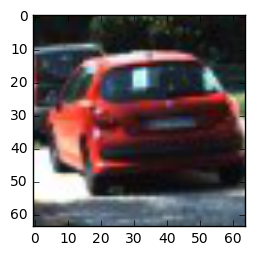

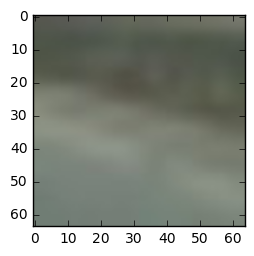

In [6]:
# Generate a random index to look at a car image
ind_cars = np.random.randint(0, len(cars))
c_image = mpimg.imread(cars[ind_cars])


plt.title("CAR - {} - {}".format(ind_cars,cars[ind_cars]))
plt.subplot(121)
plt.imshow(c_image)
plt.show()

# Generate a random index to look at a notcar image
ind_notcars = np.random.randint(0, len(notcars))
nc_image = mpimg.imread(notcars[ind_notcars])

plt.title("NOTCAR - {} - {}".format(ind_notcars, notcars[ind_notcars]))
plt.subplot(122)
plt.imshow(nc_image)
plt.show()

Here is an example of the color histogram of various color spaces for the `vehicle` class:

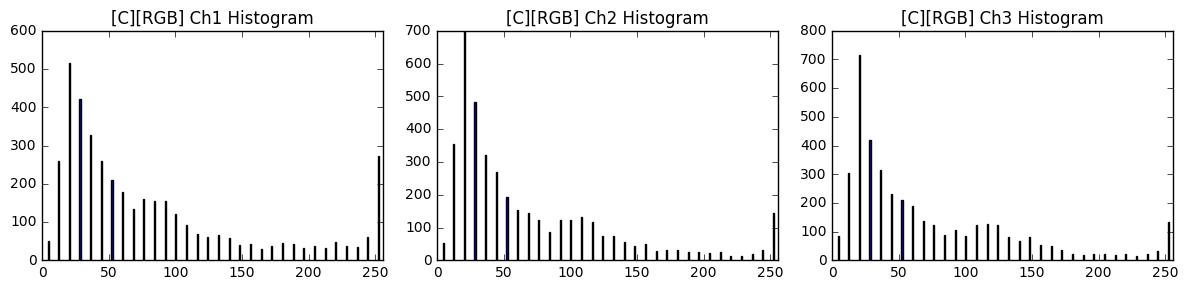

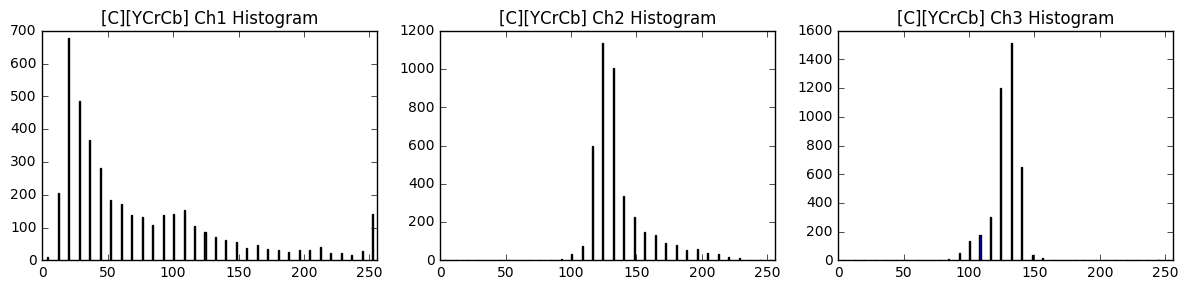

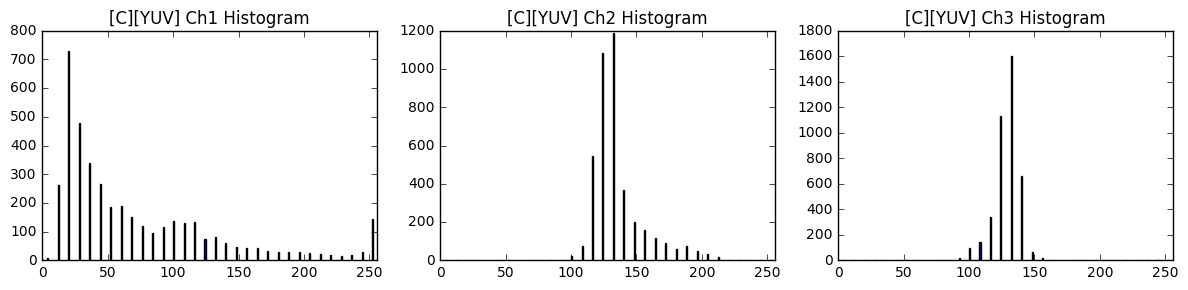

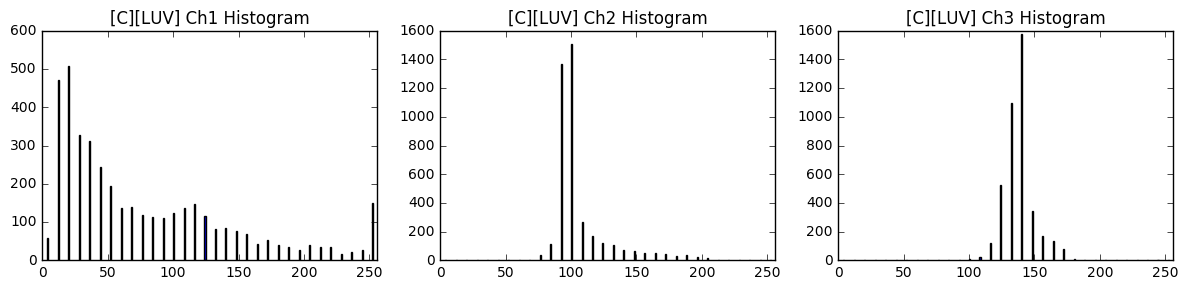

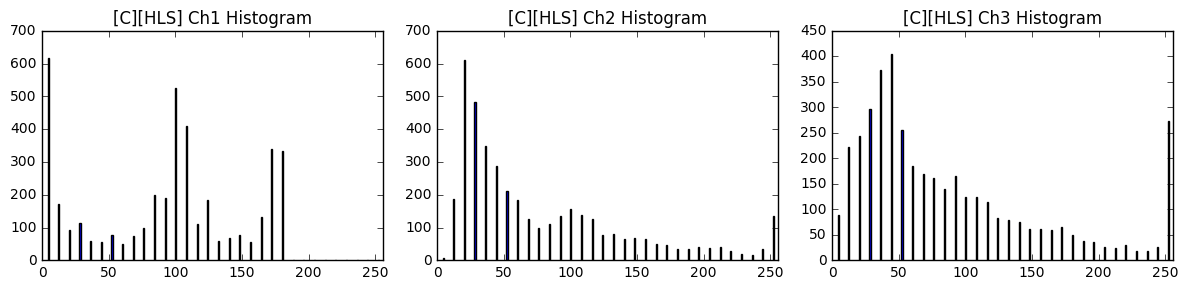

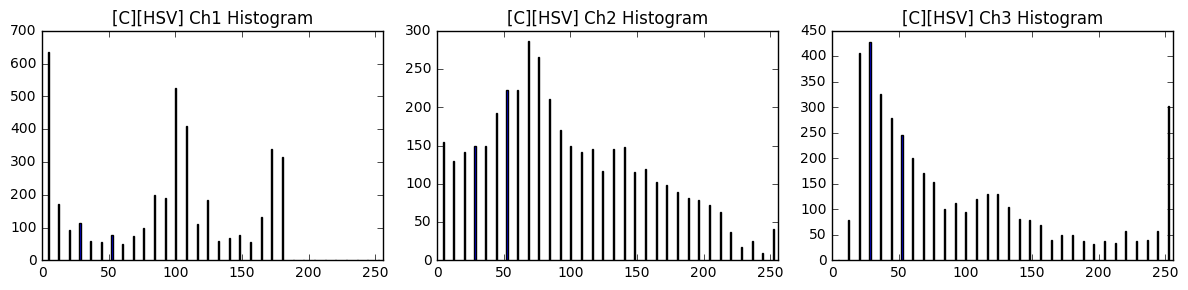

In [7]:
plot_histogram(c_image, title='[C][RGB]')
plot_histogram(cv2.cvtColor(c_image, cv2.COLOR_RGB2YCrCb), title='[C][YCrCb]')
plot_histogram(cv2.cvtColor(c_image, cv2.COLOR_RGB2YUV), title='[C][YUV]')
plot_histogram(cv2.cvtColor(c_image, cv2.COLOR_RGB2LUV), title='[C][LUV]')
plot_histogram(cv2.cvtColor(c_image, cv2.COLOR_RGB2HLS), title='[C][HLS]')
plot_histogram(cv2.cvtColor(c_image, cv2.COLOR_RGB2HSV), title='[C][HSV]')

Here is an example of the color histogram of various color spaces for the `non-vehicle` class:

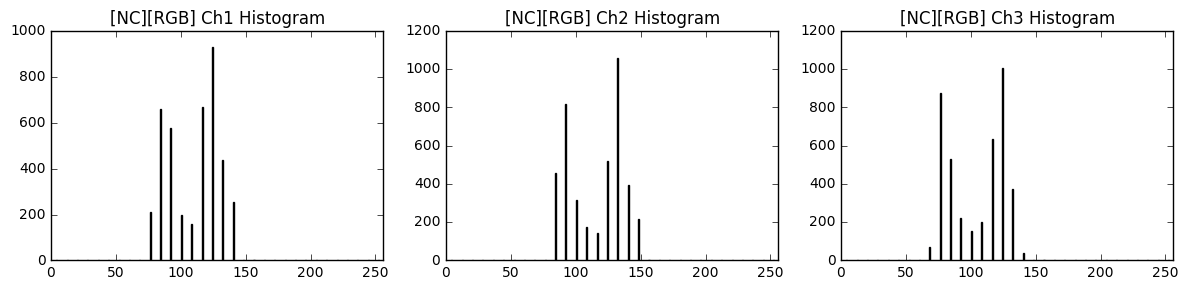

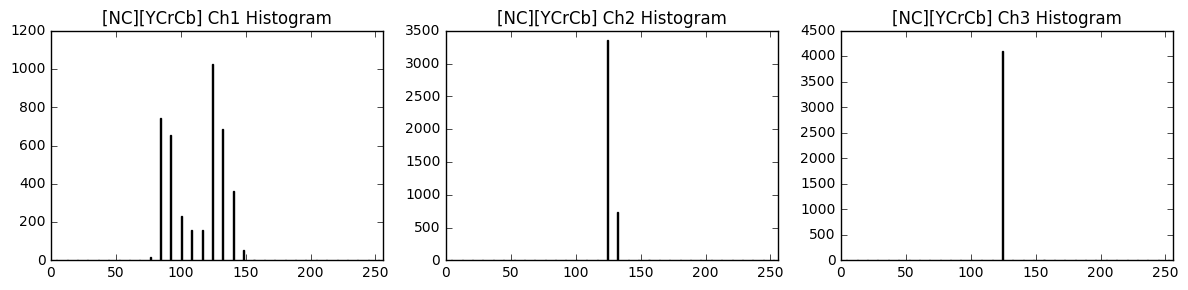

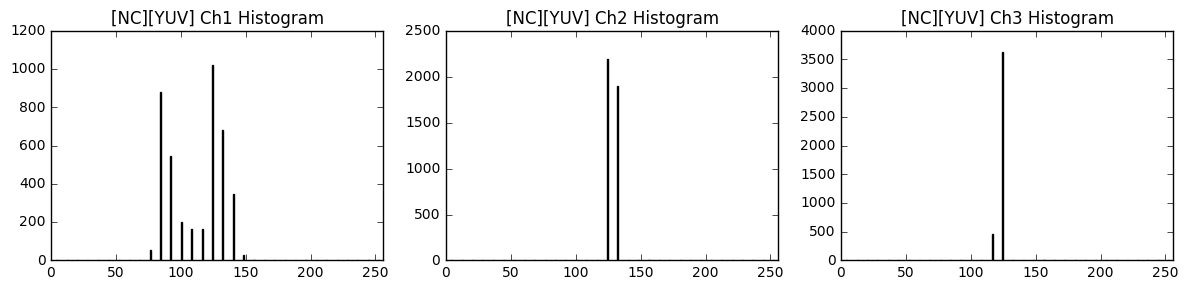

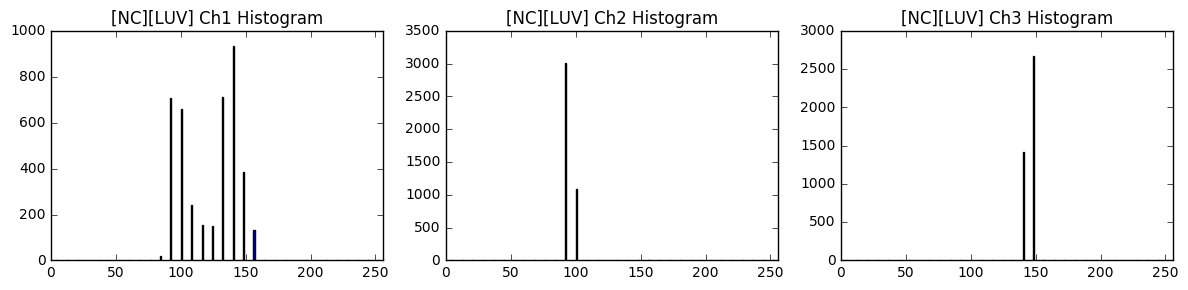

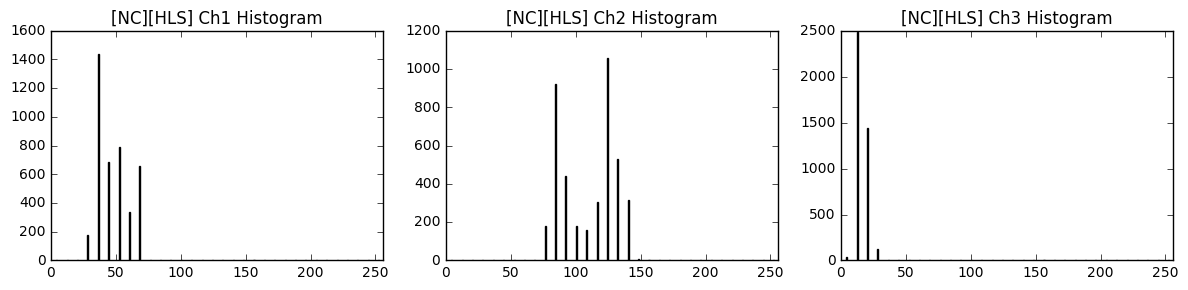

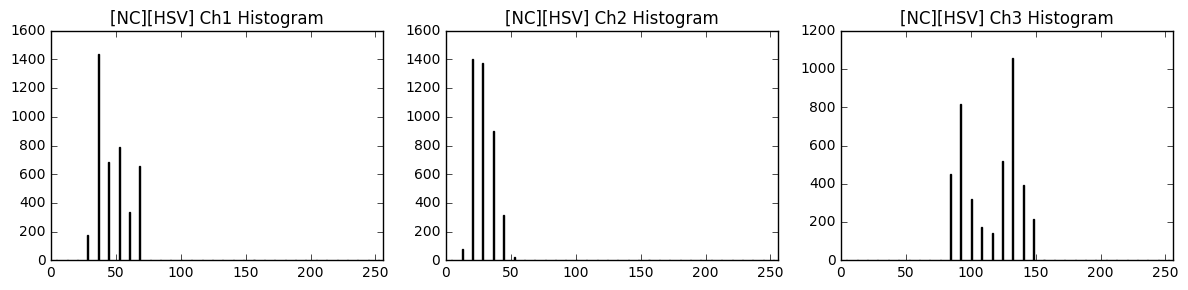

In [8]:
plot_histogram(nc_image, title='[NC][RGB]')
plot_histogram(cv2.cvtColor(nc_image, cv2.COLOR_RGB2YCrCb), title='[NC][YCrCb]')
plot_histogram(cv2.cvtColor(nc_image, cv2.COLOR_RGB2YUV), title='[NC][YUV]')
plot_histogram(cv2.cvtColor(nc_image, cv2.COLOR_RGB2LUV), title='[NC][LUV]')
plot_histogram(cv2.cvtColor(nc_image, cv2.COLOR_RGB2HLS), title='[NC][HLS]')
plot_histogram(cv2.cvtColor(nc_image, cv2.COLOR_RGB2HSV), title='[NC][HSV]')

I then explored different color spaces and different `skimage.hog()` parameters (`orientations`, `pixels_per_cell`, and `cells_per_block`).  I grabbed random images from each of the two classes and displayed them to get a feel for what the `skimage.hog()` output looks like.

Here is an example using the `YCrCb` color space and HOG parameters of `orientations=8`, `pixels_per_cell=(8, 8)` and `cells_per_block=(2, 2)`:

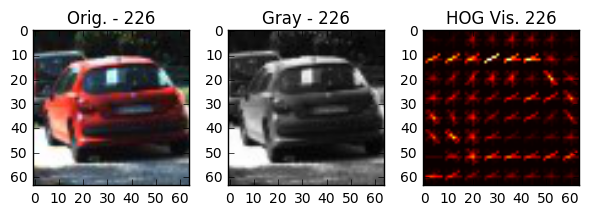

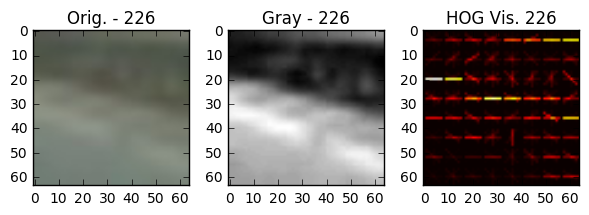

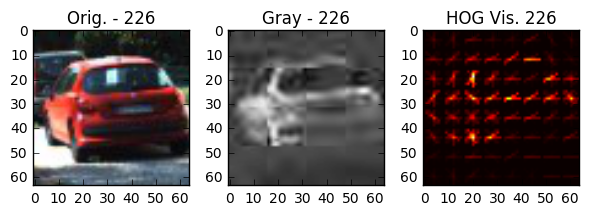

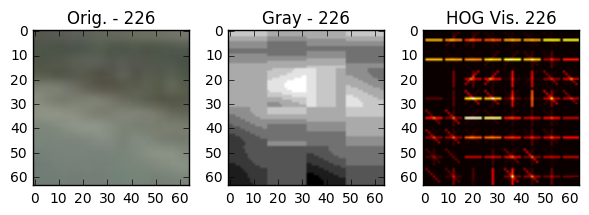

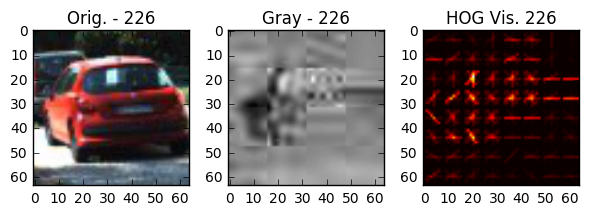

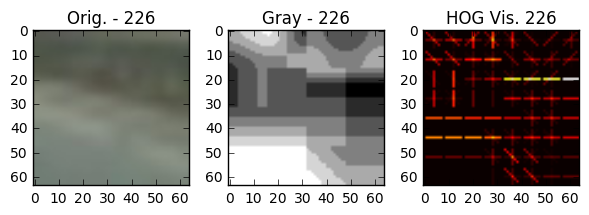

In [9]:
def extract_and_visualize(orig, gray, orient=8, pix_per_cell=8, cell_per_block=2, transform_sqrt=False):
    # Call our function with vis=True to see an image output
    features, hog_image = HOGExtractorOp(
        gray, orient, 
        pix_per_cell, cell_per_block, 
        visualize=True,
        feature_vec=False, 
        transform_sqrt=transform_sqrt
    ).output()

    # Plot the examples
    fig = plt.figure()
    plt.subplot(131)
    plt.imshow(orig)
    plt.title('Orig. - {}'.format(str(ind_cars)))
    plt.subplot(132)
    plt.imshow(gray, cmap='gray')
    plt.title('Gray - {}'.format(str(ind_cars)))
    plt.subplot(133)
    plt.imshow(hog_image, cmap='hot')
    plt.title('HOG Vis. {}'.format(str(ind_cars)))
    plt.tight_layout()


# c_ind_cars = np.random.randint(0, len(cars))
# nc_ind_cars = np.random.randint(0, len(notcars))

# Read in the image
# ind_cars = 1165
#c_image = mpimg.imread(cars[c_ind_cars])
#nc_image = mpimg.imread(notcars[nc_ind_cars])

for i in range(3):
    cspace = 'YCrCb'
#     cspace = 'YUV'
#     cspace = 'HSV'
#     cspace = 'HLS'
    c_gray = cv2.cvtColor(c_image, eval('cv2.COLOR_RGB2'+cspace))[:,:,i]
    nc_gray = cv2.cvtColor(nc_image, eval('cv2.COLOR_RGB2'+cspace))[:,:,i]


    # Define HOG parameters
    orient = 8
    pix_per_cell = 8
    cell_per_block = 2


    extract_and_visualize(c_image, c_gray, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, transform_sqrt=True)
    # extract_and_visualize(c_image, c_gray, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, transform_sqrt=False)
    
    extract_and_visualize(nc_image, nc_gray, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, transform_sqrt=True)
    # extract_and_visualize(nc_image, nc_gray, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, transform_sqrt=False)

#### 2. Explain how you settled on your final choice of HOG parameters.

I tried various combinations of parameters and the one with the highest accuracy is ultimately what I chose for my model.

I ultimately landed on using the `YCrCb` color space and HOG parameters of `orientations=7`, `pixels_per_cell=(8, 8)` and `cells_per_block=(2, 2)` because they yeilded the higest accuracy against the test set during training. I also liked how uniform the Cr and Cb color channels were more uniformly distributed in cars and less so for non-cars compared to other color spaces.

Each item outlined in the table below is initiatlized and commented out in the cell below. Feel free to have a go at it.


|  colorspace | orient | pix_per_cell | cell_per_block | hog_channel  |   accuracy   |
|:--------:|:------------:|:------------:|:------------:|:------------:|:------------:|
| YUV | 9 | 8 | 2 | 0 | 97% |
| YUV | 8 | 8 | 2 | 0 | 98% |
| YUV | 8 | 8 | 2 | ALL | 98.5% |
| YUV | 8 | 7 | 2 | ALL | 99% |
| YCrCb | 8 | 7 | 2 | ALL | 99-100% |
| YCrCb* | 7 | 8 | 2 | ALL | 99.24% |

#### 3. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

I trained a linear SVM as explained in the next few cells using the following approach:

1. I instantiate `Params` with the HOG parameters that yielded the best overall prediction accuracy against the test set.

2. I then invoke `#extract_features` which extracts HOG features from each training image for both the cars and not cars datasets passing the same parameter to each.

3. I then stack both cars and not cars datasets into a single array called `X` which correspond to my training features.

4. Using sklearn.preprocessing.StandardScaler(), I normalize my feature vectors for training my classifier. 

5. Then I apply the same scaling to each of the feature vectors.

6. Next, I created my training labels by using np.hstack which assigns the label `1` for each item from the `cars` training set and the label `0` for each item in the `notcars` training set.

7. Then I split up the data into randomized 80% training and 20% test sets using `sklearn.model_selection.train_test_split`. This automatically shuffles my dataset.

8. Using `sklearn.svm.LinearSVC`, I fit my training features and labels to the model.

9. Finally, I run a prediction against my model and print some statistics to the console below the next Jupyter Notebook cell.

In [10]:
################################################################################################################
# params = Params(colorspace='YUV', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0) #97%
# params = Params(colorspace='YUV', orient=8, pix_per_cell=8, cell_per_block=2, hog_channel=0) #98%
# params = Params(colorspace='YUV', orient=8, pix_per_cell=8, cell_per_block=2, hog_channel='ALL') #98.5%
# params = Params(colorspace='YUV', orient=8, pix_per_cell=7, cell_per_block=2, hog_channel='ALL') #99%
# params = Params(colorspace='YCrCb', orient=8, pix_per_cell=7, cell_per_block=2, hog_channel='ALL') #99-100%
# params = Params(colorspace='YCrCb', orient=7, pix_per_cell=4, cell_per_block=2, hog_channel='ALL') #99-100%
# params = Params(colorspace='YCrCb', orient=9, pix_per_cell=4, cell_per_block=4, hog_channel='ALL') #99-100%
params = Params(colorspace='YCrCb', orient=7, pix_per_cell=8, cell_per_block=2, hog_channel='ALL') #99-100%
################################################################################################################

t=time.time()
car_features = extract_features(cars, color_space=params.colorspace, orient=params.orient, 
                        pix_per_cell=params.pix_per_cell, cell_per_block=params.cell_per_block, 
                        hog_channel=params.hog_channel)
notcar_features = extract_features(notcars, color_space=params.colorspace, orient=params.orient, 
                        pix_per_cell=params.pix_per_cell, cell_per_block=params.cell_per_block, 
                        hog_channel=params.hog_channel)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',params.orient,'orientations',params.pix_per_cell,
    'pixels per cell and', params.cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC(C=0.01)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = len(X_test)
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

11.32 Seconds to extract HOG features...
Using: 7 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 7284
0.69 Seconds to train SVC...
Test Accuracy of SVC =  1.0
My SVC predicts:  [ 1.  1.  1.  0.  1.  0.  1.  1.  1.  1.  0.  0.  1.  0.  0.  0.  1.  1.
  0.  0.  0.  0.  1.  1.  0.  0.  1.  1.  0.  1.  1.  1.  0.  0.  1.  1.
  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  0.  1.  0.  1.  1.  0.  0.  1.  0.  1.  0.  0.  1.  1.
  1.  1.  0.  1.  0.  0.  0.  1.  1.  0.  1.  1.  1.  1.  1.  0.  1.  1.
  0.  1.  1.  0.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  0.
  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  1.  1.  0.  1.  0.
  0.  1.  1.  0.  0.  1.  1.  1.  0.  1.  0.  0.  1.  1.  0.  1.  1.  0.
  1.  1.  0.  0.  1.  0.  1.  1.  1.  1.  1.  1.  0.  0.  1.  0.  0.  0.
  0.  1.  0.  1.  1.  0.  0.  0.  0.  1.  1.  0.  1.  0.  1.  1.  1.  0.
  0.  0.  0.  1.  1.  0.  0.  0.  1.  0.  0.  1.  0.  1.  1.  0.

---

### Sliding Window Search

#### 1. Describe how (and identify where in your code) you implemented a sliding window search.  How did you decide what scales to search and how much to overlap windows?

##### Vehicle Detection Pipeline Choices Explained

I commented each section of my pipeline in **VehicleDetectionOp#perform** (declared below in the Video Implementation section). Here is the documented algorithm for your viewing pleasure which explains precisely how I implemented my sliding window search:

```python
def perform(self):
    result = self.__img
    if self.__img is not None:
        svc = self.__svc
        X_scaler = self.__X_scaler
        params = self.__params
        image = self.__img
        # Uncomment the following line if you extracted training
        # data from .png images (scaled 0 to 1 by mpimg) and the
        # image you are searching is a .jpg (scaled 0 to 255)
        image = image.astype(np.float32)/255
        # Build our collection of search windows.
        # Since I know I'm in the far left lane in the project video, 
        # I decided to scan only the center and right lanes for 
        # performance purposes.
        #
        # After trying out over 100 different window kernel size and 
        # overlap permutations, I discovered that having a very high 
        # overlap (i.e., >=0.7) yielded more possible detections and 
        # the greatest anomoly detection accuracy after applying 
        # the heat map.
        #
        # Having a higher overlap has its pros and cons so the below 
        # windows have a healthy balance of performance and accuracy. 
        #
        # I also noticed that cars are not actually square so sliding 
        # a square kernel across non-square objects introduces errors. 
        # So, after trying out 7-8 different aspect ratios, I settled 
        # on a simple 5:4 aspect ratio giving me slighty more accurate 
        # readings across each frame.
        #
        # If I had to take a guess right now, I'd say my detection 
        # algorithm is as accurate as my LinearSVC classifier (~99.24%). 
        # There are still a few frames where the algorithm misses its 
        # target but I am satisfied with my first pass and look forward 
        # to peer feedback for tips and tricks.
        #
        # In addition, introducing a Vehicle class which is essentially 
        # responsible for tracking a single vehicle over time will ensure 
        # that even if I miss-calculate one out of seven frame, I'd 
        # essentially keep a running average from the previous 6 frames 
        # to fall back to.
        overlap = 0.9
        windows = []
        # I start off with a single 64px tall window search space with 0.9 
        # overlap to slide a 120x96 kernel across the horizon to pick up 
        # vehicles farther away. I wanted to apply the highest overlap at 
        # the smaller kernel size in the smallest search space because it 
        # is more accurate but also takes a lot longer to execute.
        windows += slide_window(image, x_start_stop=[704, None], y_start_stop=[375, 439], xy_window=(int(96*1.25), 96), xy_overlap=(overlap, overlap)) 
        # Next, I define a 128px tall search space with essentially a 0.81 
        # overlap to slide a 120x96 kernel accross. This essentially adds a 
        # bit more confidence around any detections from the previous window 
        # search. This also means that it was necessary for me to increase 
        # my heatmap threshold to remove any anomolies around the actual 
        # vehicle (e.g., road signs).
        windows += slide_window(image, x_start_stop=[768, None], y_start_stop=[375, 567], xy_window=(int(96*1.25), 96), xy_overlap=(overlap*0.9, overlap*0.9))
        # Finally, I sweep a 280x224 kernel across the entire search space 
        # with the full 0.9 overlap to pick up vehicles that may be right 
        # next to me or just entering the frame (i.e., closer to me).
        windows += slide_window(image, x_start_stop=[768, None], y_start_stop=[375, 695], xy_window=(int(224*1.25), 224), xy_overlap=(overlap*1., overlap*1.))
        # With the optimal windows identified, let's predict whether there's 
        # a vehicle inside of each window.
        #
        # This is by far the most process intensive method so it's imperative 
        # we address all performance concerns prior to reaching this phase.
        # 
        # As it stands right now with the current windows, it take ~2-2.5s per 
        # frame.
        t=time.time()
        hot_windows = search_windows(image, windows, svc, X_scaler, color_space=params.colorspace, 
                                spatial_size=params.spatial_size, hist_bins=params.hist_bins, 
                                orient=params.orient, pix_per_cell=params.pix_per_cell, 
                                cell_per_block=params.cell_per_block, 
                                hog_channel=params.hog_channel, spatial_feat=params.spatial_feat, 
                                hist_feat=params.hist_feat, hog_feat=params.hog_feat)                       
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to search and locate {} windows...'.format(len(hot_windows)))

        # visualize the detected windows if visualization is enabled
        if self.vis_detections:
            # Draw the detected windows on top of the original image.
            window_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=3)
            PlotImageOp(window_img, title="Detected Vehicles").perform()

        # A clever algorithm I was about to implement prior to obtaining optimal detections 
        # with the current searchable windows was to actually track the heat map over 
        # time instead of averaging windows over time. I didnt' end up using it in the end 
        # but I am leaving my code in here in hopes I can experiment with it later on.
        #
        # The idea behind this algorithm is to start off with a base threshold and 
        # to continue to add +1 to new detections to the heat map for n frames then 
        # start from scratch after each nth frame (i.e., cool the heatmap down).
        base_thresh = 7
        if True: #self.heat == None or (self.current_frame%base_thresh) == 0:
            self.heat = np.zeros_like(image[:,:,0]).astype(np.float)
        heat = self.heat
        # (UNUSED) have a more lenient theshold by decaying over time
        heat_thresh = (base_thresh+((base_thresh*(self.current_frame%base_thresh))*((self.current_frame%base_thresh)/base_thresh)))
        # Weed out anomolies by accepting detections where at least 
        # 5 windows were predicted to have a vehicle in it.
        heatmap = add_heat(heat, hot_windows)
        heatmap = apply_threshold(heatmap, 5)
        self.heat = heatmap
        labels = label(heatmap)
        print(labels[1], 'cars found')
        # visualize the labels if visualization is enabled
        if self.vis_labels:
            PlotImageOp(labels[0], cmap='gray').perform()
        # visualize the heatmap if visualization is enabled
        if self.vis_heat:
            final_map = np.clip(heatmap-2, 0, 255)
            PlotImageOp(final_map, cmap='hot').perform()
        # Draw the labels onto the original image
        result = draw_labeled_bboxes(np.copy(image*255), labels)
    return self._apply_output(result)
```

### Training final Pipeline LinearSVC Classifier

1. First I instantiated the *`big`* dataset with over 8000 car and not car samples.

2. Then I instantiate the Params class which is fed into the `#train_classifier` method declared in the next cell.

3. `#train_classifier` instantiates LinearSVC with a C of 0.01 allowing for some noise (I used [this Stats exchance answer](http://stats.stackexchange.com/a/31067) for inspiration). 

4. Finally, `#train_classifier` returns the instance of LinearSVC and the StandardScaler used to predict against inside of the **VehicleDetectionOp#perform** method later on in this notebook.

> My final classifier resulted in 99.24% accurate against 20% of the training set and expects a scaled feature vector of size `7284` at prediction time.

In [11]:
ds = CarsNotCarsDatasetOp(dataset_size='big').perform()
cars = ds.cars()
notcars = ds.notcars()


#sample_size = 1000
#c_random_idxs = np.random.randint(0,len(cars), sample_size)
#nc_random_idxs = np.random.randint(0,len(notcars), sample_size)
#test_cars = np.array(cars)[c_random_idxs] # cars[0:c_sample_size]
#test_notcars = np.array(notcars)[nc_random_idxs] # notcars[0:nc_sample_size]

test_cars = cars
test_notcars = notcars

print('    # Cars: ' + str(len(test_cars)))
print('# Not cars: ' + str(len(test_notcars)))

    # Cars: 8792
# Not cars: 8968


In [12]:
def train_classifier(params, test_cars, test_notcars, C=1.):
    t=time.time()
    car_features = extract_features(test_cars, color_space=params.colorspace, 
                            spatial_size=params.spatial_size, hist_bins=params.hist_bins, 
                            orient=params.orient, pix_per_cell=params.pix_per_cell, 
                            cell_per_block=params.cell_per_block, 
                            hog_channel=params.hog_channel, spatial_feat=params.spatial_feat, 
                            hist_feat=params.hist_feat, hog_feat=params.hog_feat)
    
    notcar_features = extract_features(test_notcars, color_space=params.colorspace, 
                            spatial_size=params.spatial_size, hist_bins=params.hist_bins, 
                            orient=params.orient, pix_per_cell=params.pix_per_cell, 
                            cell_per_block=params.cell_per_block, 
                            hog_channel=params.hog_channel, spatial_feat=params.spatial_feat, 
                            hist_feat=params.hist_feat, hog_feat=params.hog_feat)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract HOG features...')

    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:',params.orient,'orientations',params.pix_per_cell,
        'pixels per cell and', params.cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    # svc = LinearSVC(C=1.2) # 98.76%
    svc = LinearSVC(C=C)
    # from sklearn.ensemble import AdaBoostClassifier
    # svc = AdaBoostClassifier(learning_rate=0.1, algorithm='SAMME.R', n_estimators=50) # 86%
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    
    return svc, X_scaler

# params = Params(
#     colorspace='YCrCb', 
#     orient=7, 
#     pix_per_cell=8, 
#     cell_per_block=2, 
#     hog_channel='ALL', 
#     spatial_size=(32, 32), 
#     hist_bins=32,
#     spatial_feat=True,
#     hist_feat=True,
#     hog_feat=True,
#     y_start_stop=[400, 656]
# ) #98.37%

params = Params(
    colorspace='YCrCb', 
    orient=7,
    pix_per_cell=8, 
    cell_per_block=2, 
    hog_channel='ALL', 
    spatial_size=(32, 32), 
    hist_bins=32,
    spatial_feat=True,
    hist_feat=True,
    hog_feat=True
) #99.21%

svc, X_scaler = train_classifier(params, test_cars, test_notcars, C=0.01)

83.0 Seconds to extract HOG features...
Using: 7 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 7284
40.5 Seconds to train SVC...
Test Accuracy of SVC =  0.9882


#### Sliding Window Performance Measurement Cell

I used this cell to fine-tune my sliding window algorithm and accepted a `<3s` performance hit per sample as it resulted in the fewest number of anomolies and a tighter window around the detected vehicles.

In [13]:
images = []
# images = ['notes/bbox-example-image.jpg']
images += glob.glob('test_images/*.jpg')
# images += ['test_images/test1.jpg']

results = []
for image in images:
    image = mpimg.imread(image)
    #print(image.shape[0:2][::-1])
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255
    # array of windows to search for cars
    windows = []
    # create sliding windows
    t=time.time()
    overlap = 0.9
    windows += slide_window(image, x_start_stop=[704, None], y_start_stop=[375, 439], xy_window=(int(96*1.25), 96), xy_overlap=(overlap, overlap)) 
    windows += slide_window(image, x_start_stop=[768, None], y_start_stop=[375, 567], xy_window=(int(96*1.25), 96), xy_overlap=(overlap*0.9, overlap*0.9))
    windows += slide_window(image, x_start_stop=[768, None], y_start_stop=[375, 695], xy_window=(int(224*1.25), 224), xy_overlap=(overlap*1., overlap*1.))
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to aggregate {} sliding windows...'.format(len(windows)))
    # search the sliding windows
    t=time.time()
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=params.colorspace, 
                            spatial_size=params.spatial_size, hist_bins=params.hist_bins, 
                            orient=params.orient, pix_per_cell=params.pix_per_cell, 
                            cell_per_block=params.cell_per_block, 
                            hog_channel=params.hog_channel, spatial_feat=params.spatial_feat, 
                            hist_feat=params.hist_feat, hog_feat=params.hog_feat)                       
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to search and locate {} windows...'.format(len(hot_windows)))
    results.append((image, hot_windows))

0.0 Seconds to aggregate 725 sliding windows...
4.52 Seconds to search and locate 111 windows...
0.0 Seconds to aggregate 725 sliding windows...
4.29 Seconds to search and locate 0 windows...
0.0 Seconds to aggregate 725 sliding windows...
3.87 Seconds to search and locate 10 windows...
0.0 Seconds to aggregate 725 sliding windows...
3.77 Seconds to search and locate 118 windows...
0.0 Seconds to aggregate 725 sliding windows...
3.8 Seconds to search and locate 82 windows...
0.0 Seconds to aggregate 725 sliding windows...
3.76 Seconds to search and locate 104 windows...


#### 2. Show some examples of test images to demonstrate how your pipeline is working.  What did you do to optimize the performance of your classifier?

Ultimately I searched on two scales using YCrCb 3-channel HOG features plus spatially binned color and histograms of color in the feature vector, which provided a nice result.  

The ultimate step I took to optimize the performane of the classifier was to build different windows with various sizes based on knowledge that cars will be smaller closer to horizon and larget closer to my vehicle. Then I custom tuned the overlap for each window to achieve respectable performance so I didn't spend several hours to process the project video. Anything under 3 seconds was good enough for to achieve accurate results.

Here are some example images:

![400_IN_FINAL.jpg](output_images/project_video/400_IN_FINAL.jpg)

![600_IN_FINAL.jpg](output_images/project_video/600_IN_FINAL.jpg)

![800_IN_FINAL.jpg](output_images/project_video/800_IN_FINAL.jpg)

![900_IN_FINAL.jpg](output_images/project_video/900_IN_FINAL.jpg)

![1100_IN_FINAL.jpg](output_images/project_video/1100_IN_FINAL.jpg)

![1200_IN_FINAL.jpg](output_images/project_video/1200_IN_FINAL.jpg)

![1260_IN_FINAL.jpg](output_images/project_video/1260_IN_FINAL.jpg)

---

### Video Implementation

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)

##### YouTube Videos

Please use these as your baseline reveiew.

[Video of Vehicle and Advance Lane Detection](https://youtu.be/asIqUYuIkM0)

[Video of Vehicle Detection Only](https://youtu.be/jsrWyRCsjJo)

##### Vehicle and Adanced Lane Finding Detection Only

In [14]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('project_video_final_with_advanced_lane_detection.mp4'))

##### Vehicle Detection Only

In [15]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('project_video_final.mp4'))

In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip

class VehicleDetectionOp(PipelineOp):
    def __init__(self, svc, X_scaler, params, vis=False):
        PipelineOp.__init__(self)
        self.__svc = svc
        self.__X_scaler = X_scaler
        self.__params = params
        self.__img = None
        self.current_frame = -1
        # visualization flags
        self.vis_detections = vis
        self.vis_labels = vis
        self.vis_heat = vis
    
    def detect_vehicles(self, image, current_frame):
        self.current_frame = current_frame
        self.__img = image
        return self.perform().output()
    
    def perform(self):
        result = self.__img
        if self.__img is not None:
            svc = self.__svc
            X_scaler = self.__X_scaler
            params = self.__params
            image = self.__img
            # Uncomment the following line if you extracted training
            # data from .png images (scaled 0 to 1 by mpimg) and the
            # image you are searching is a .jpg (scaled 0 to 255)
            image = image.astype(np.float32)/255
            # Build our collection of search windows.
            # Since I know I'm in the far left lane in the project video, 
            # I decided to scan only the center and right lanes for 
            # performance purposes.
            #
            # After trying out over 100 different window kernel size and 
            # overlap permutations, I discovered that having a very high 
            # overlap (i.e., >=0.7) yielded more possible detections and 
            # the greatest anomoly detection accuracy after applying 
            # the heat map.
            #
            # Having a higher overlap has its pros and cons so the below 
            # windows have a healthy balance of performance and accuracy. 
            #
            # I also noticed that cars are not actually square so sliding 
            # a square kernel across non-square objects introduces errors. 
            # So, after trying out 7-8 different aspect ratios, I settled 
            # on a simple 5:4 aspect ratio giving me slighty more accurate 
            # readings across each frame.
            #
            # If I had to take aguess right now, I'd say my detection 
            # algorithm is as accurate as my LinearSVC classifier (~99.21%). 
            # There are still a few frames where the algorithm misses its 
            # target but I am satisfied with my first pass and look forward 
            # to peer feedback for tips and tricks.
            #
            # In addition, introducing a Vehicle class which is essentially 
            # responsible for tracking a single vehicle over time will ensure 
            # that even if I miss-calculate one our of seven frame, I'd 
            # essentially keep a running average from the previous 6 frames 
            # to fall back to.
            overlap = 0.9
            windows = []
            # I start off with a single 64px tall window search space with 0.9 
            # overlap to slide a 120x96 kernel across the horizon to pick up 
            # vehicles farther away. I wanted to apply the highest overlap at 
            # the smaller kernel size in the smallest search space because it 
            # is more accurate but also takes a lot longer to execute.
            windows += slide_window(image, x_start_stop=[704, None], y_start_stop=[375, 439], xy_window=(int(96*1.25), 96), xy_overlap=(overlap, overlap)) 
            # Next, I define a 128px tall search space with essentially a 0.81 
            # overlap to slide a 120x96 kernel accross. This essentially adds a 
            # bit more confidence around any detections from the previous window 
            # search. This also means that it was necessary for me to increase 
            # my heatmap threshold to remove any anomolies around the actual 
            # vehicle (e.g., road signs).
            windows += slide_window(image, x_start_stop=[768, None], y_start_stop=[375, 567], xy_window=(int(96*1.25), 96), xy_overlap=(overlap*0.9, overlap*0.9))
            # Finally, I sweep a 280x224 kernel across the entire search space 
            # with the full 0.9 overlap to pick up vehicles that may be right 
            # next to me or just entering the frame (i.e., closer to me).
            windows += slide_window(image, x_start_stop=[768, None], y_start_stop=[375, 695], xy_window=(int(224*1.25), 224), xy_overlap=(overlap*1., overlap*1.))
            # With the optimal windows identified, let's predict whether there's 
            # a vehicle inside of each window.
            #
            # This is by far the most process intensive method so it's imperative 
            # we address all performance concerns prior to reaching this phase.
            # 
            # As it stands right now with the current windows, it take ~2-2.5s per 
            # frame.
            t=time.time()
            hot_windows = search_windows(image, windows, svc, X_scaler, color_space=params.colorspace, 
                                    spatial_size=params.spatial_size, hist_bins=params.hist_bins, 
                                    orient=params.orient, pix_per_cell=params.pix_per_cell, 
                                    cell_per_block=params.cell_per_block, 
                                    hog_channel=params.hog_channel, spatial_feat=params.spatial_feat, 
                                    hist_feat=params.hist_feat, hog_feat=params.hog_feat)                       
            t2 = time.time()
            print(round(t2-t, 2), 'Seconds to search and locate {} windows...'.format(len(hot_windows)))

            # visualize the detected windows if visualization is enabled
            if self.vis_detections:
                # Draw the detected windows on top of the original image.
                window_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=3)
                PlotImageOp(window_img, title="Detected Vehicles").perform()

            # A clever algorithm I was about to implement prior to obtaining optimal detections 
            # with the current searchable windows was to actually track the heat map over 
            # time instead of averaging windows over time. I didnt' end up using it in the end 
            # but I am leaving my code in here in hopes I can experiment with it later on.
            #
            # The idea behind this algorithm is to start off with a base threshold and 
            # to continue to add +1 to new detections to the heat map for n frames then 
            # start from scratch after each nth frame (i.e., cool the heatmap down).
            base_thresh = 7
            if True: #self.heat == None or (self.current_frame%base_thresh) == 0:
                self.heat = np.zeros_like(image[:,:,0]).astype(np.float)
            heat = self.heat

            # have a more lenient theshold by decaying over time
            heat_thresh = (base_thresh+((base_thresh*(self.current_frame%base_thresh))*((self.current_frame%base_thresh)/base_thresh)))

            # Weed out anomolies by excepting detections where at least 
            # 5 windows were predicted to have a vehicle in it.
            heatmap = add_heat(heat, hot_windows)
            heatmap = apply_threshold(heatmap, 5)
            self.heat = heatmap
            labels = label(heatmap)
            print(labels[1], 'cars found')
            
            # visualize the heatmap if visualization is enabled
            if self.vis_labels:
                PlotImageOp(labels[0], cmap='gray').perform()
            
            if self.vis_heat:
                final_map = np.clip(heatmap-2, 0, 255)
                PlotImageOp(final_map, cmap='hot').perform()

            # Draw the labels onto the original image
            result = draw_labeled_bboxes(np.copy(image*255), labels)
        return self._apply_output(result)
        

class PipelineRunner:
    def __init__(self, lane_assist_op, vehicle_detection_op, detect_lane=True, processed_images_save_dir=None):
        # Lane Detection operation algorithm used in #process_image
        self.lane_assist_op = lane_assist_op
        # Vehicle Detection operation algorithm used in #process_image
        self.vehicle_detection_op = vehicle_detection_op
        # used as a reference when saving images or leveraging windowed algorithms
        self.current_frame = -1
        # Flag indicator whether to draw detected lane surface onto final image
        self.detect_lane = detect_lane
        # Subdirector of /processed_images (an unversioned directory for all processed images)
        self.__processed_images_save_dir = processed_images_save_dir
        # Our pre-trained LinearSVC classifier used to predict against
        self.svc = svc
        # Scaler used to compute final feature vectors fet into classifier at prediction time
        self.X_scaler = X_scaler
        # Unused - Heat map used to track detected vehicles over a period of time (frames)
        self.heat = None
        
    def process_video(self, src_video_path, dst_video_path, audio=False):
        self.current_frame = -1
        # ensures all saved images for this video are created inside a subfolder 
        # corresponding to the video name
        self.__processed_images_save_dir = os.path.basename(src_video_path).split('.')[0]+'/'
        # Call our #process_image method for each frame 
        VideoFileClip(src_video_path).fl_image(self.process_image).write_videofile(dst_video_path, audio=audio)
    
    def process_image(self, image):
        self.current_frame += 1
        # save IN if we got it
        self.__save_image(image, 'IN')
        # Detect lane
        if self.detect_lane == True:
            subdir = '{}{}'.format(self.__processed_images_save_dir, self.current_frame)
            image = self.lane_assist_op.process_image(image, subdir).output()        
        # Detect vehicles
        image = self.vehicle_detection_op.detect_vehicles(image, self.current_frame)
        # Save final if we got it
        self.__save_image(image, 'OUT')
        return image
    
    def __save_image(self, image, name):
        if self.__processed_images_save_dir != None:
            cv2.imwrite('processed_images/{}{}_{}.jpg'.format(self.__processed_images_save_dir, self.current_frame, name), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))


# Calibrates our camera and sets the `calibration_op` global 
# variable used by the LaneDetectionOp
calibrate_camera()
# Lane detection op (from P4) used by PipelineRunner
lane_assist_op = LaneDetectionOp(
    calibration_op,
    margin=100,
    kernel_size=15,
    sobelx_thresh=(20,100),
    sobely_thresh=(20,100),
    mag_grad_thresh=(20,250),
    dir_grad_thresh=(0.3, 1.3),
    color_space='HSV',
    color_channel=2
)
# Vehicle detection operation used by PipelineRunner
vehicle_detection_op = VehicleDetectionOp(
    svc, 
    X_scaler, 
    params,
    vis=False
)
# PipelineRunner which reads in a single image or source video and detects the 
# lane (when detect_lane=True) and vehicles in each video frame.
pipeline = PipelineRunner(
    lane_assist_op, 
    vehicle_detection_op, 
    detect_lane=True, 
    processed_images_save_dir='samples'
)
# See how well my pipeline performs against all .jpg images inside test_images directory
if False:
    images = []
#     images += ['notes/bbox-example-image.jpg']
#     images += glob.glob('test_images/*.jpg')
#     images += glob.glob('test_images/test3.jpg')
    for img_path in images:
        result = pipeline.process_image(mpimg.imread(img_path))
        PlotImageOp(result*255, title="{} - FINAL".format(img_path), cmap=None).perform()
# Run pipeline against the test_video.mp4
if False:
    pipeline.process_video('test_video.mp4', 'test_video_final.mp4')
# Run pipeline against the main project_video.mp4
if False:
    pipeline.process_video('project_video.mp4', 'project_video_final.mp4')

#### 2. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

I recorded the positions of positive detections in each frame of the video.  From the positive detections I created a heatmap and then thresholded that map to identify vehicle positions.  I then used `scipy.ndimage.measurements.label()` to identify individual blobs in the heatmap.  I then assumed each blob corresponded to a vehicle.  I constructed bounding boxes to cover the area of each blob detected.  

In the above cell, please find the **VehicleDetectionOp** class which handles all of the work necessary to detect and draw boxes around vehicles. More specifically, the entire algorithm, which leverages many methods provided to us during class, is encapsulated inside of **VehicleDetectionOp#perform**.

Here is a code snippet taken from **VehicleDetectionOp#perform** which creates a heatmap, thresholds it to identify vehicle positions, then identified number of detected vehicles along with their relative positioning using scipy.ndimage.measurements.label(), and finally drew boxes on top of the source image:

```python
# Weed out anomolies by excepting detections where at least 
# 5 windows were predicted to have a vehicle in it.
heat = np.zeros_like(image[:,:,0]).astype(np.float)
heatmap = add_heat(heat, hot_windows)
heatmap = apply_threshold(heatmap, 5)
self.heat = heatmap

# using `scipy.ndimage.measurements.label()` to identify individual blobs in the heatmap
labels = label(heatmap)
print(labels[1], 'cars found')

# constructing bounding boxes to cover the area of each blob detected
result = draw_labeled_bboxes(np.copy(image*255), labels)
```

Here's an example result showing the heatmap from a series of frames of video, the result of `scipy.ndimage.measurements.label()` and the bounding boxes then overlaid on the last frame of video:

### Here are seven frames and their corresponding heatmaps:

3.75 Seconds to search and locate 75 windows...
2 cars found


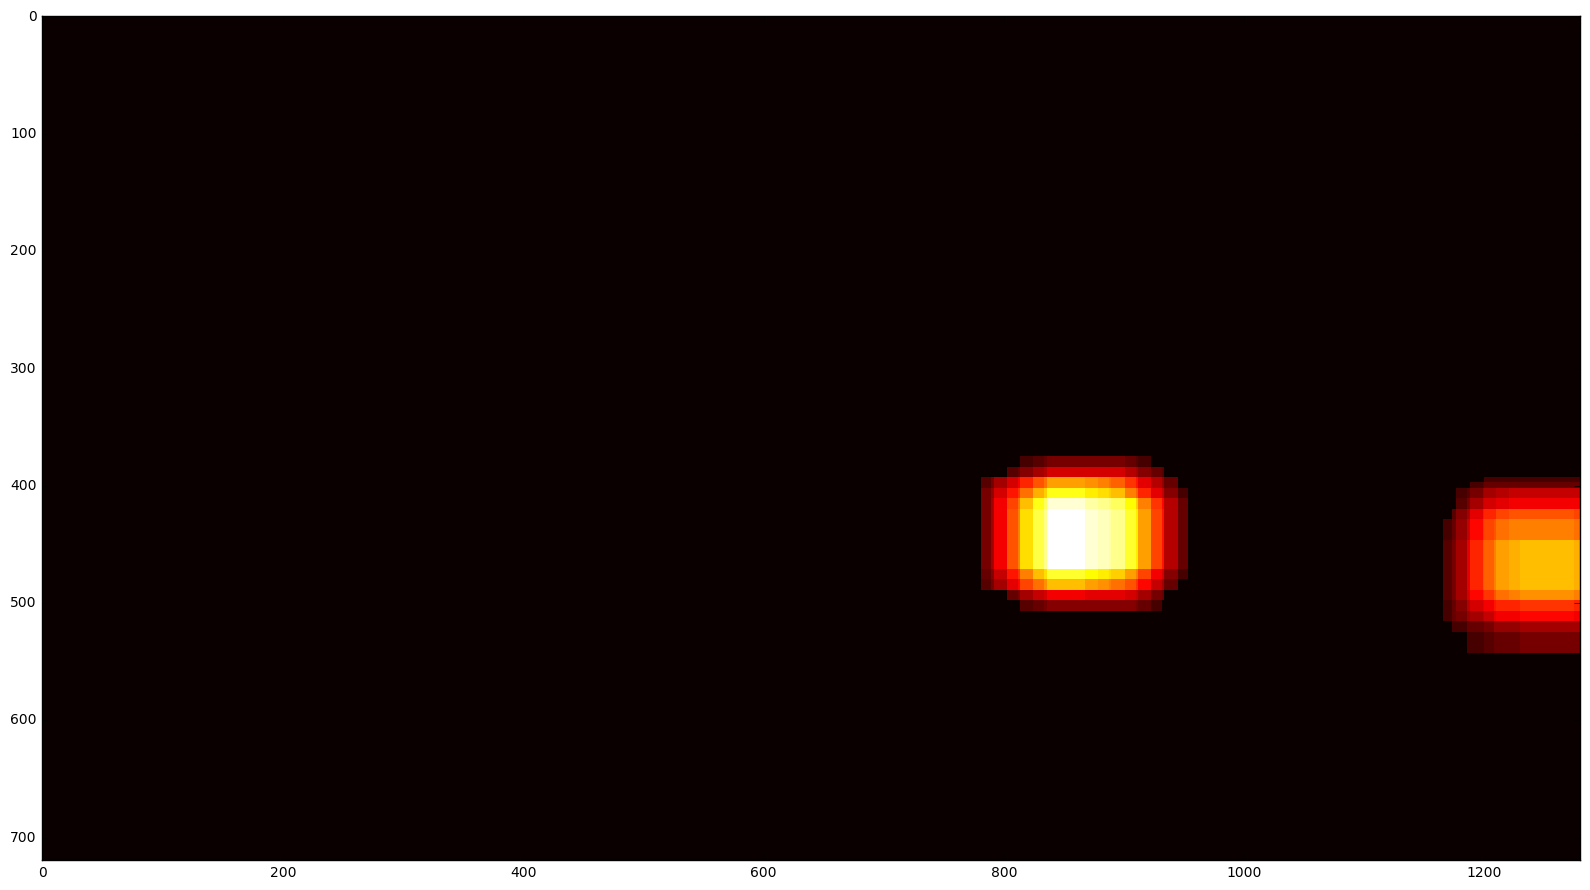

3.7 Seconds to search and locate 37 windows...
1 cars found


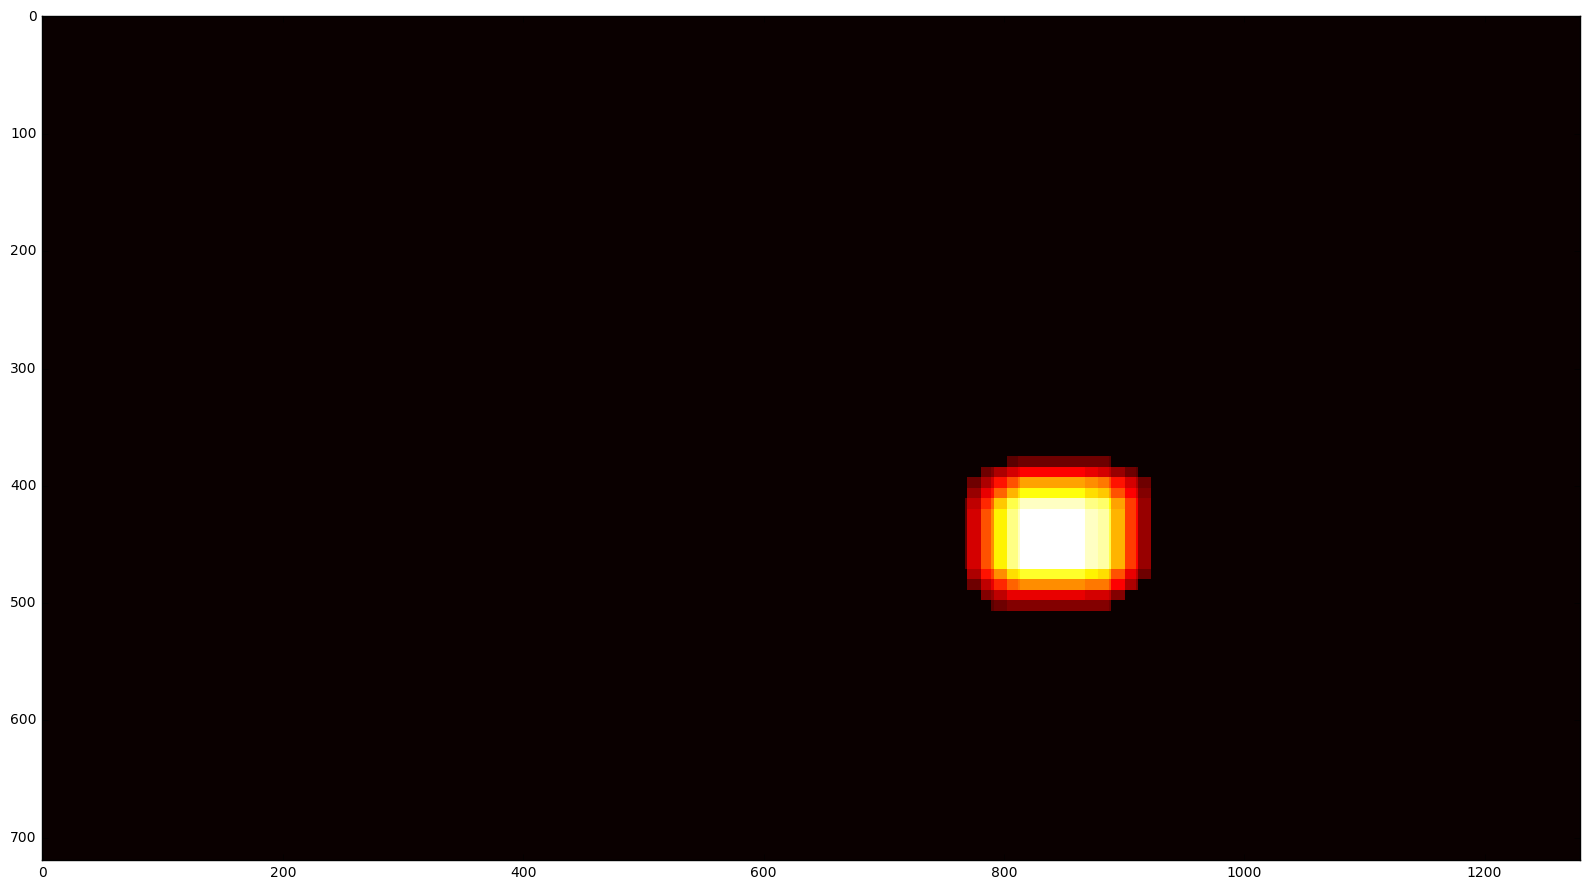

3.76 Seconds to search and locate 96 windows...
2 cars found


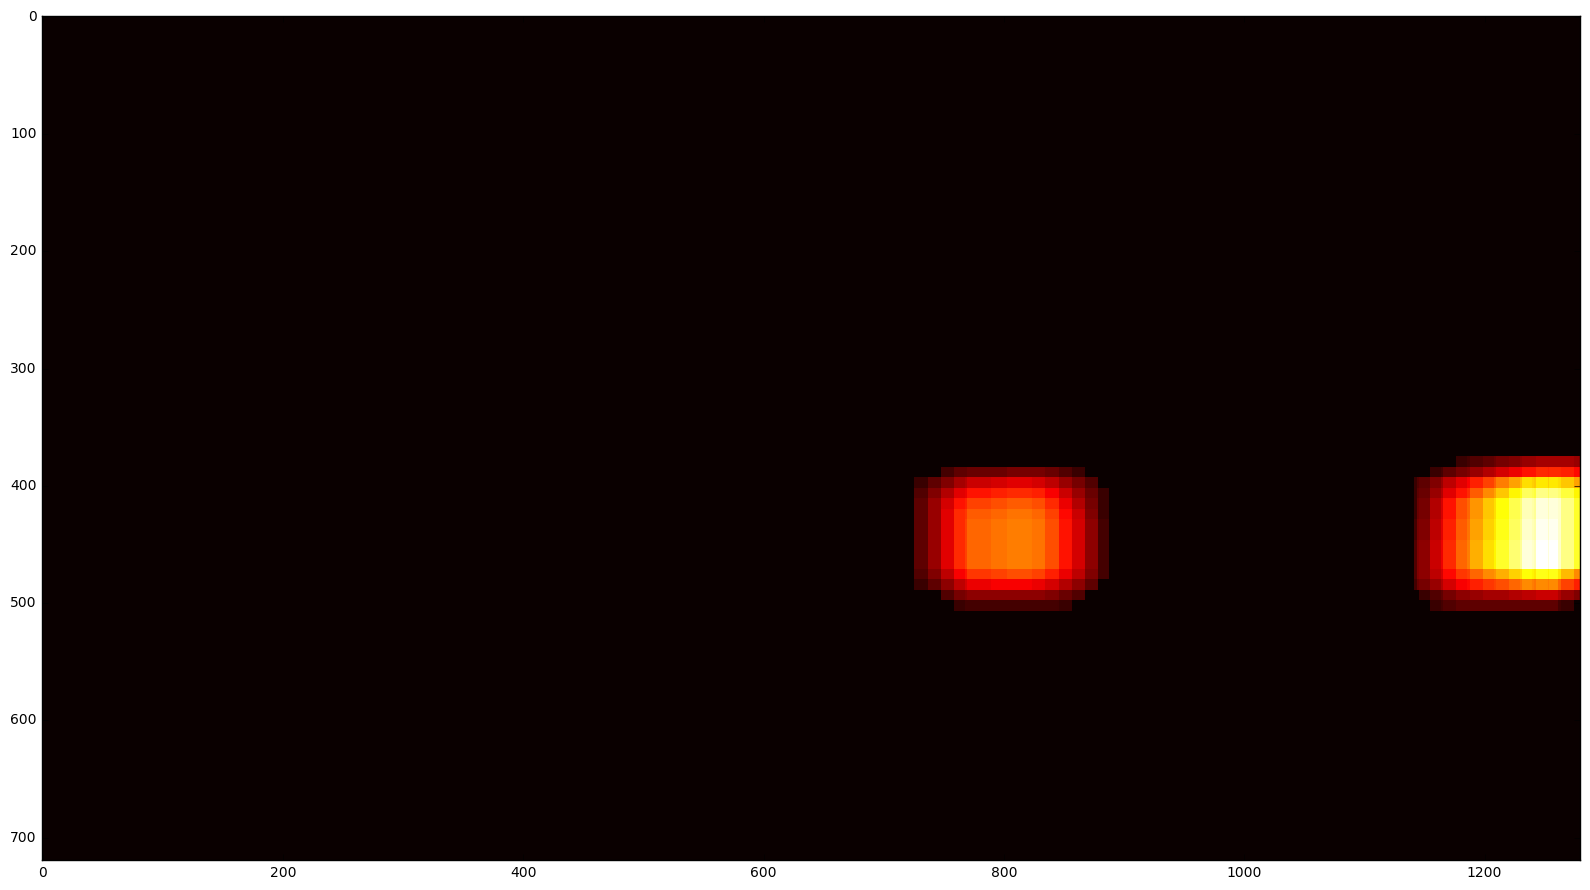

3.8 Seconds to search and locate 49 windows...
1 cars found


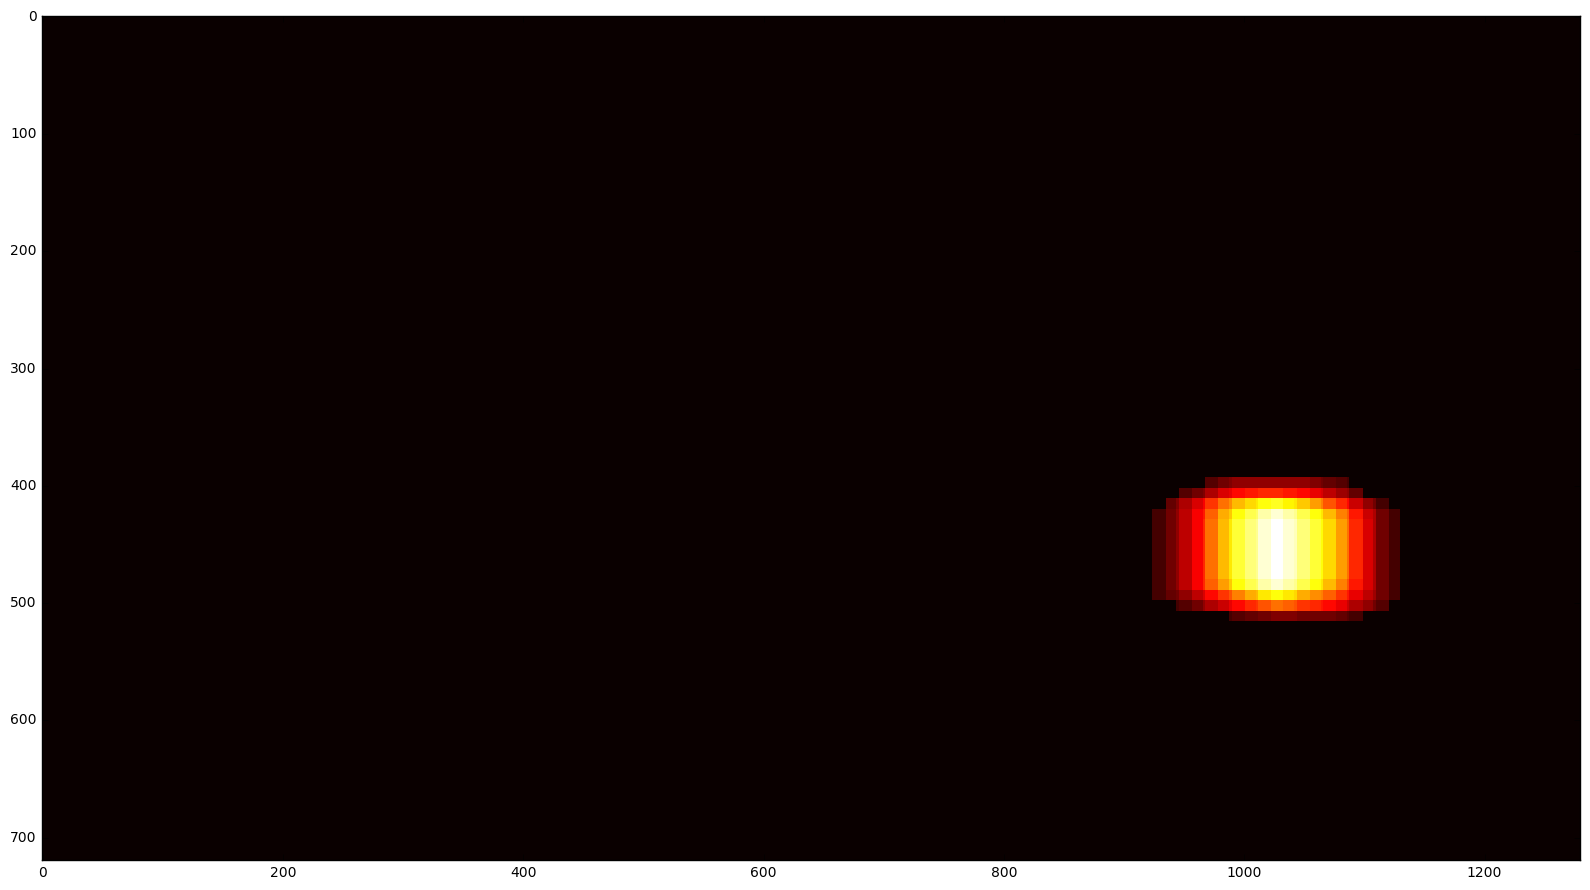

3.78 Seconds to search and locate 34 windows...
1 cars found


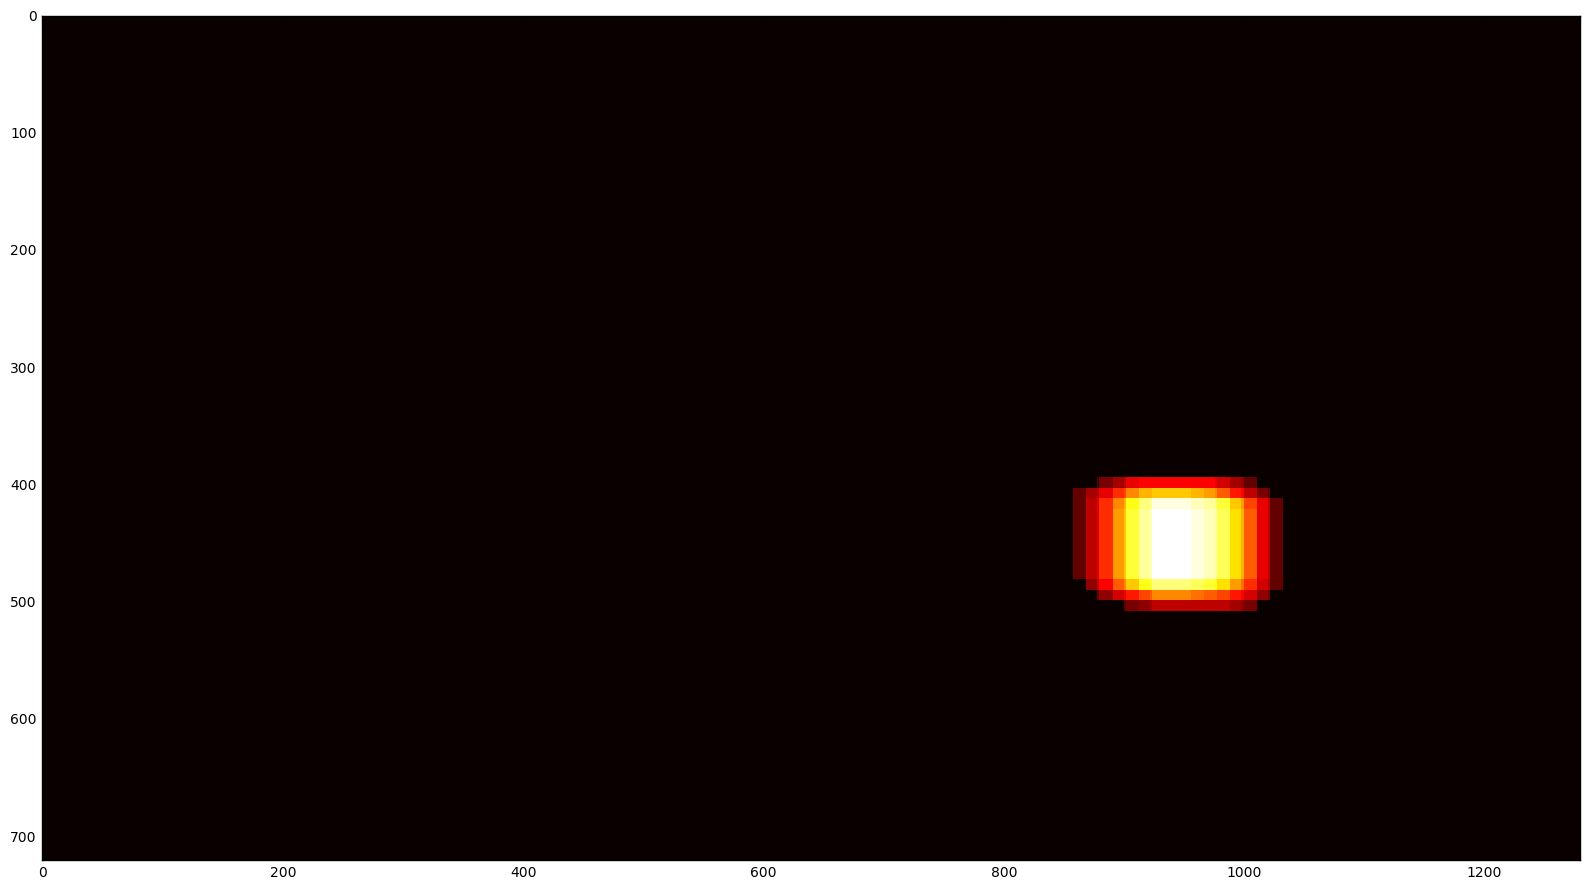

3.78 Seconds to search and locate 89 windows...
1 cars found


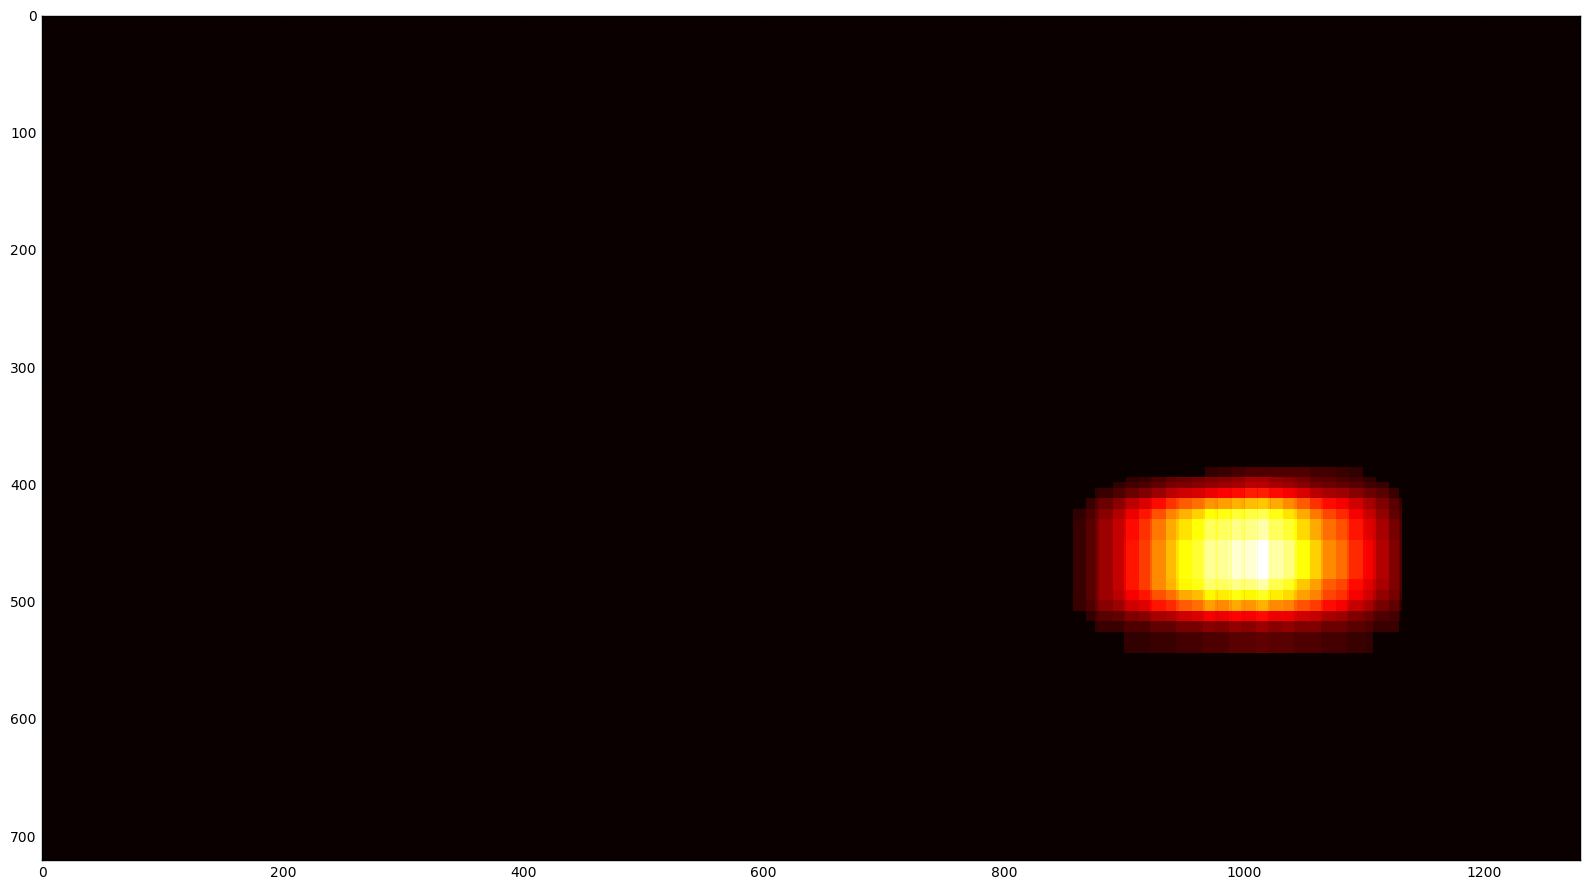

2.96 Seconds to search and locate 113 windows...
1 cars found


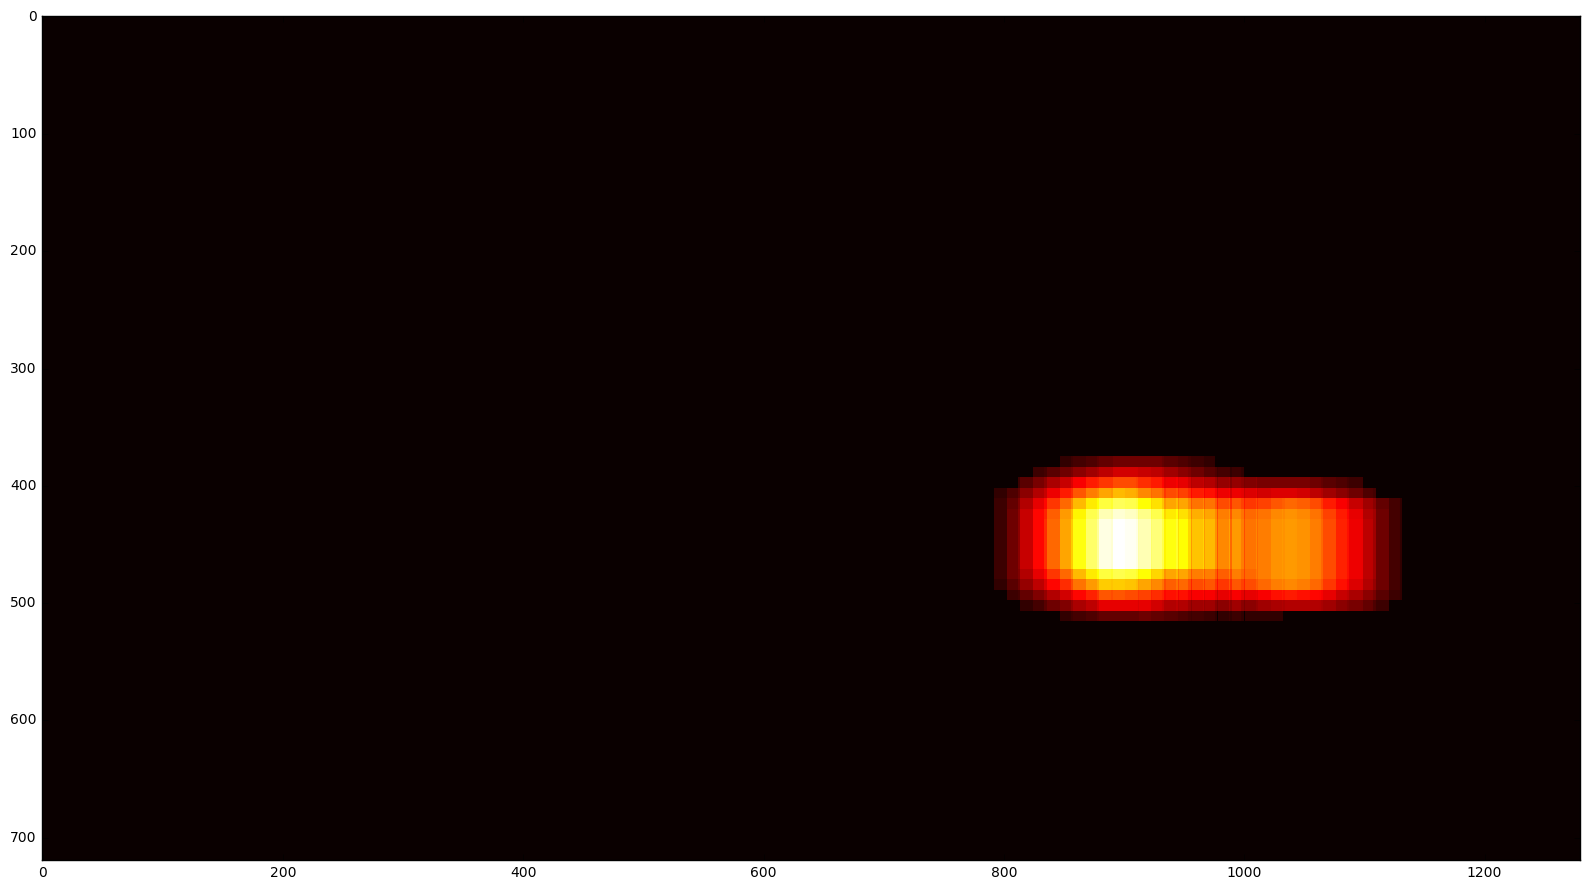

In [17]:
images = glob.glob('output_images/project_video/*_IN.jpg')
vehicle_detection_op.vis_detections = False
vehicle_detection_op.vis_labels = False
vehicle_detection_op.vis_heat = True
for img_path in images:
    result = pipeline.process_image(mpimg.imread(img_path))

### Here is the output of `scipy.ndimage.measurements.label()` on the integrated heatmap from all seven frames:

3.27 Seconds to search and locate 75 windows...
2 cars found


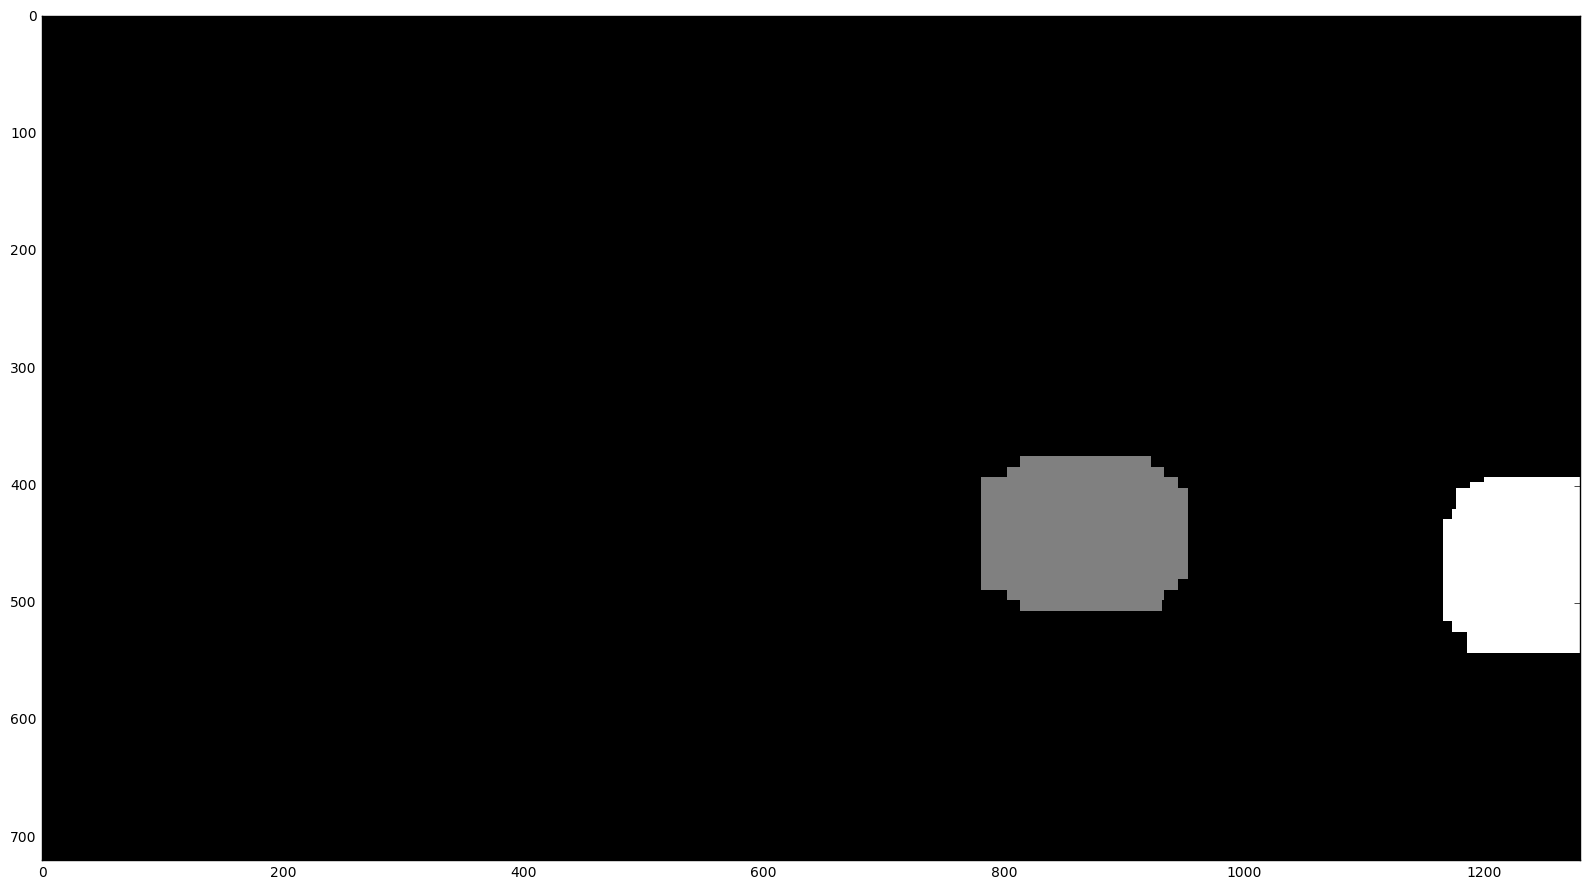

2.98 Seconds to search and locate 37 windows...
1 cars found


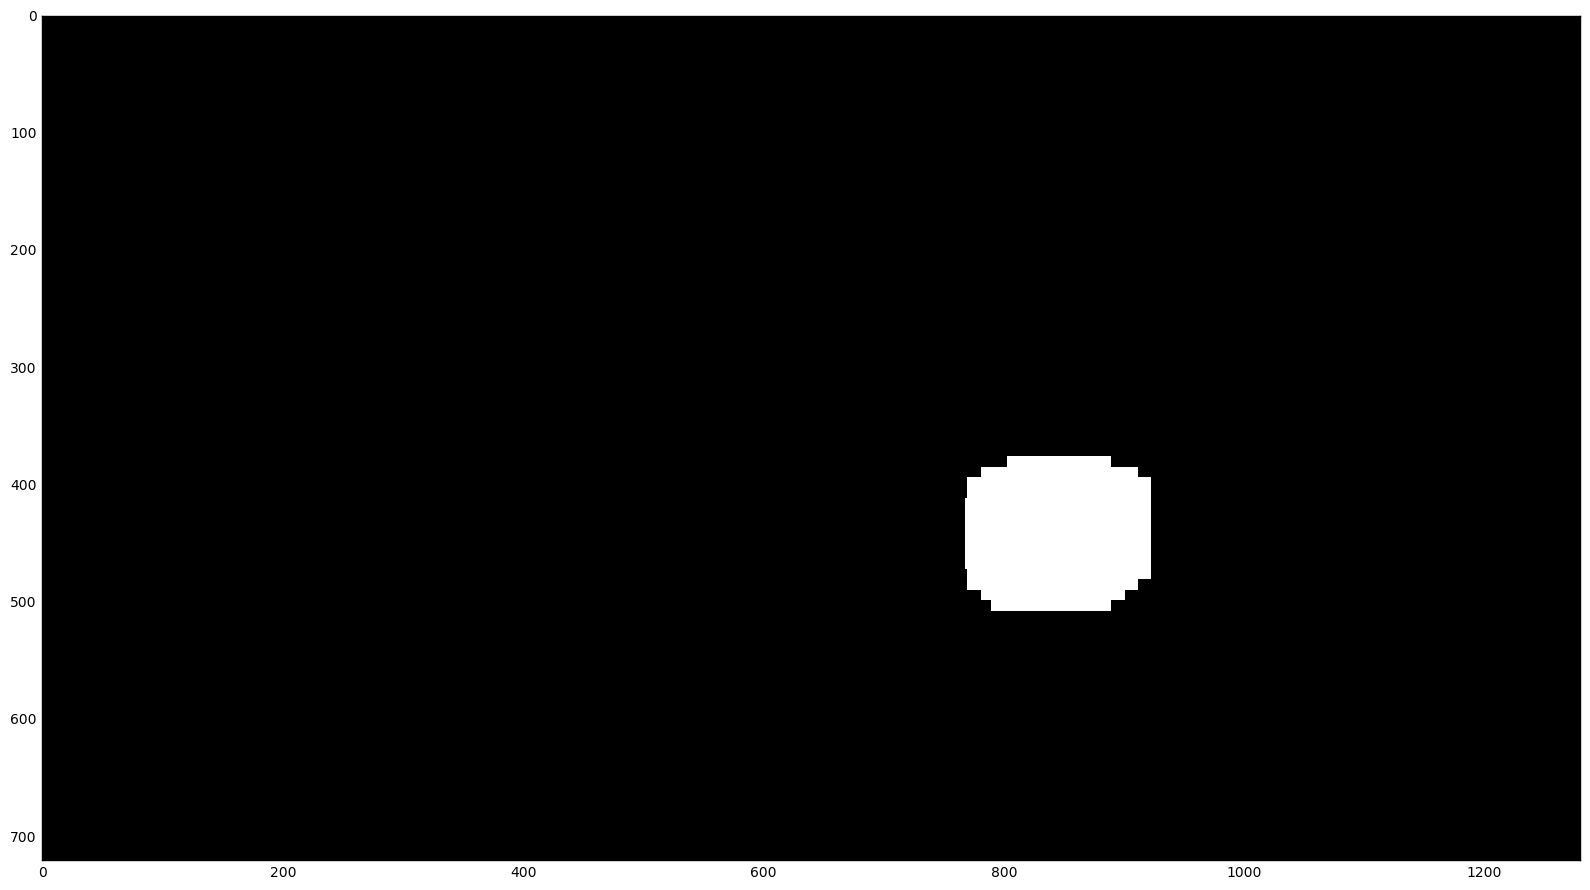

3.04 Seconds to search and locate 96 windows...
2 cars found


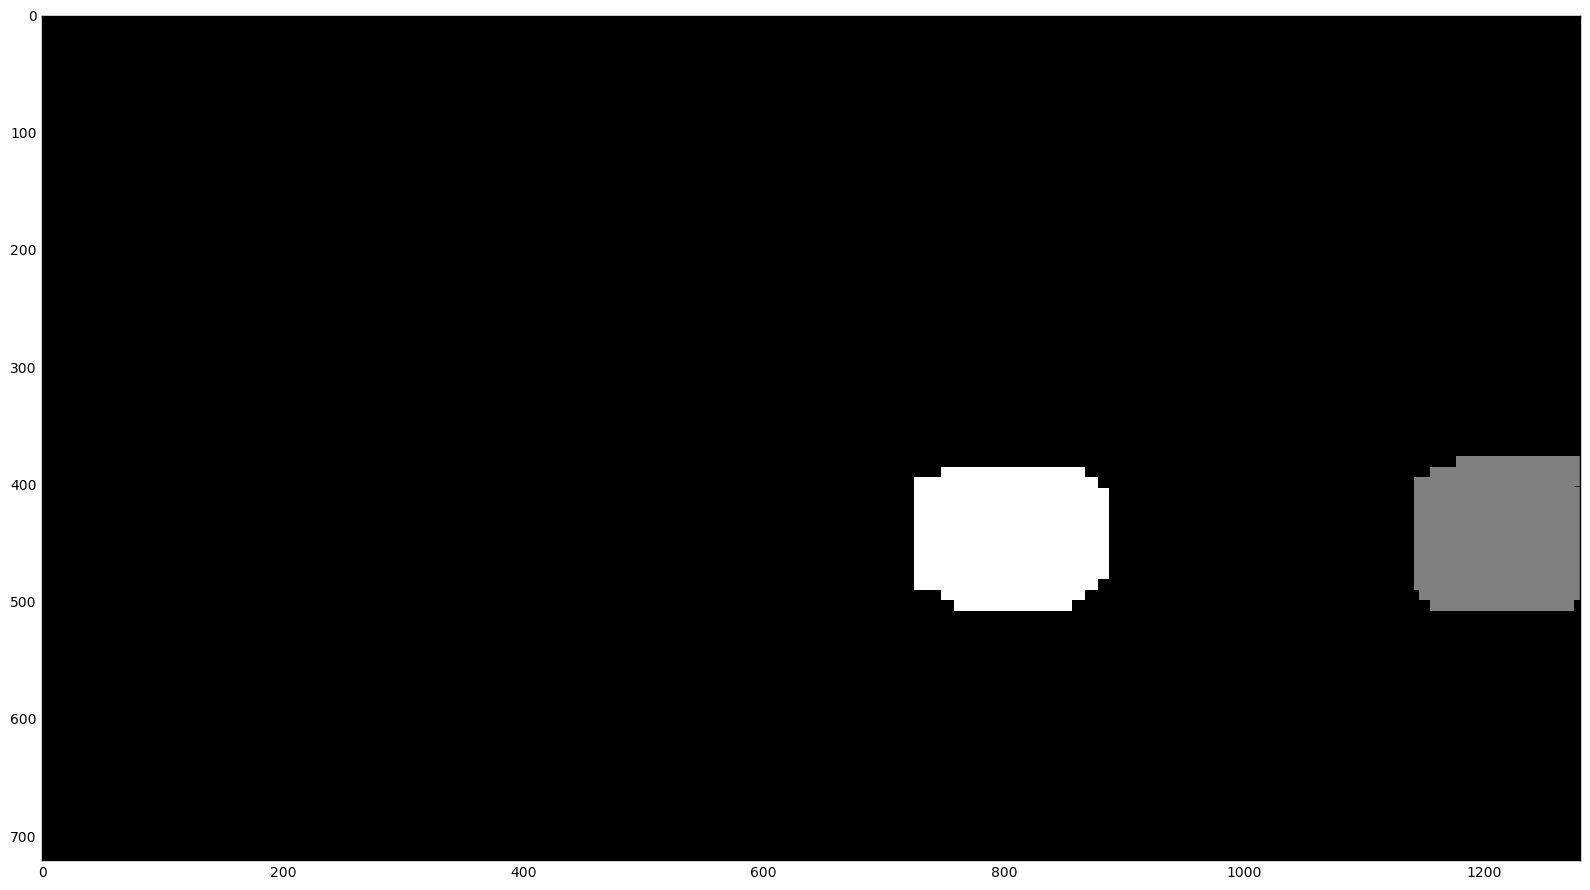

3.11 Seconds to search and locate 49 windows...
1 cars found


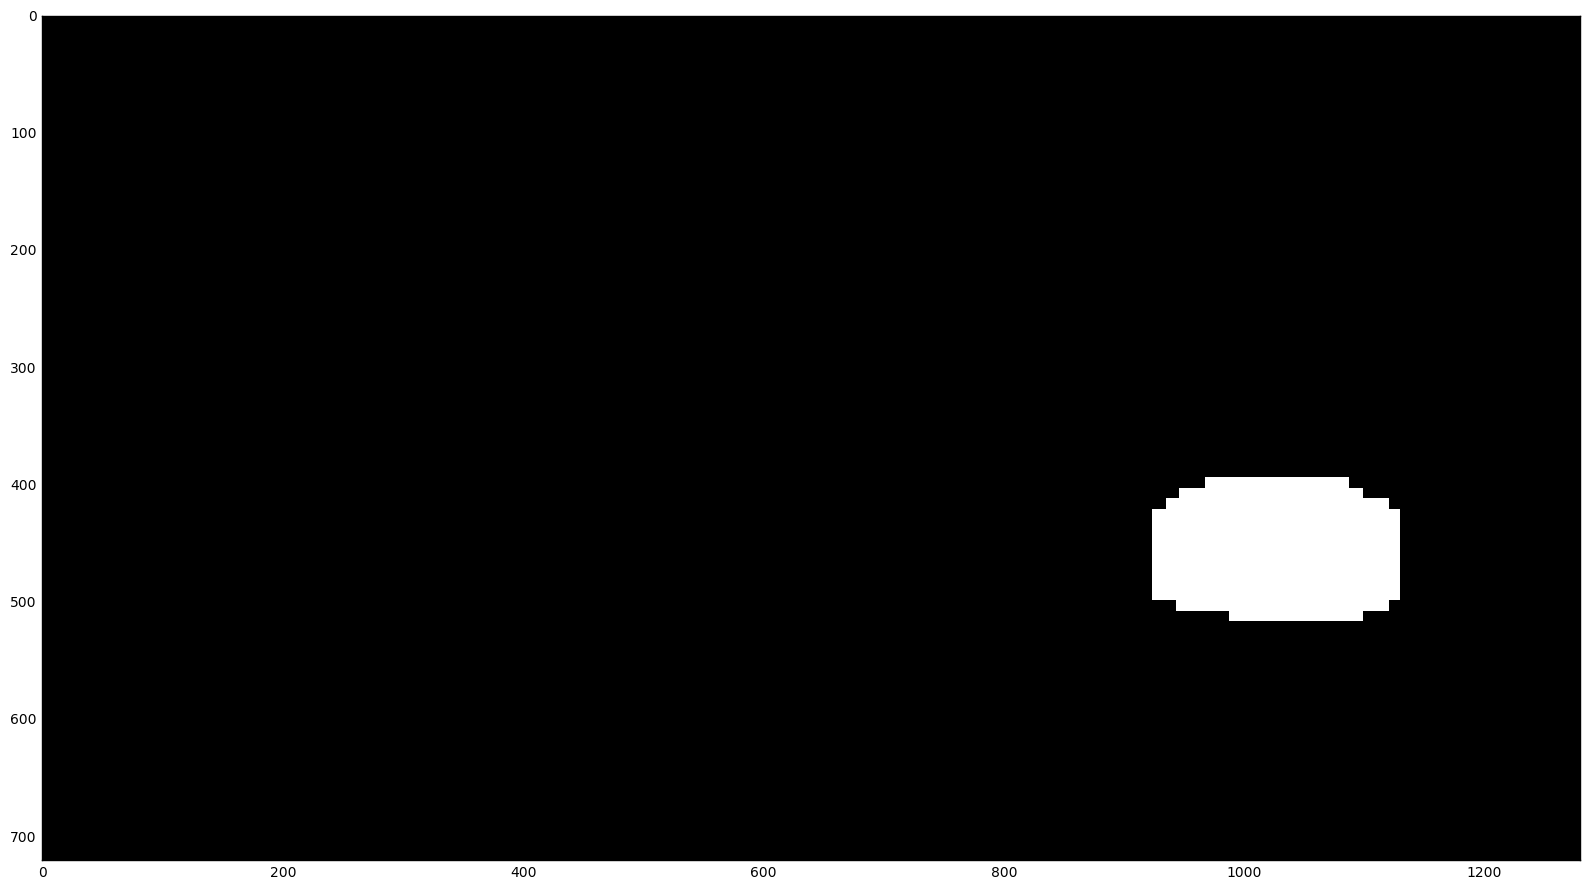

3.02 Seconds to search and locate 34 windows...
1 cars found


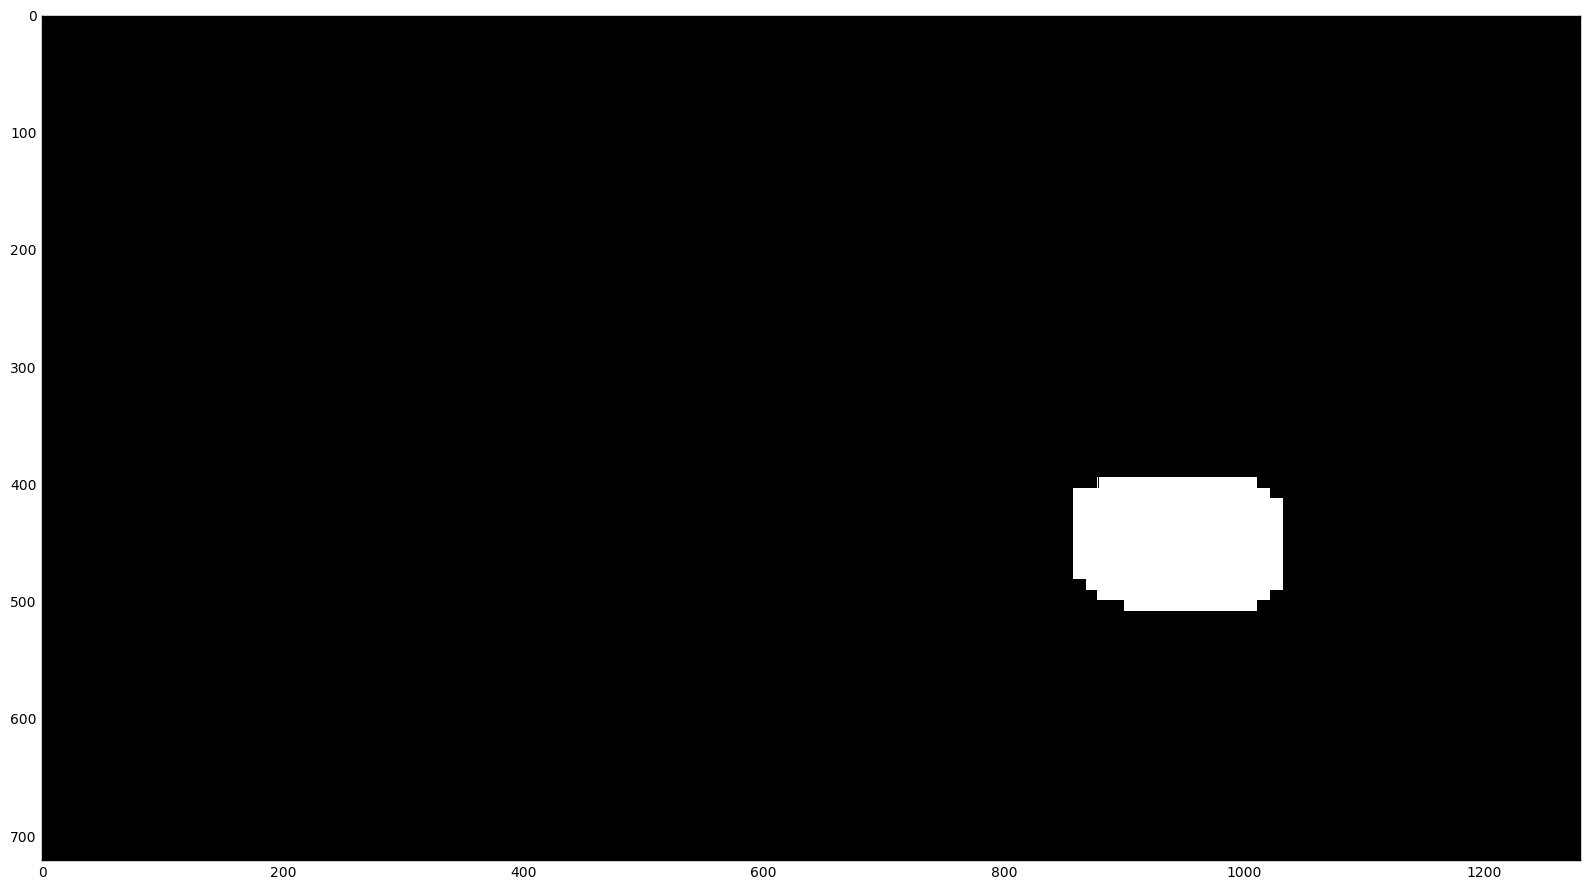

2.63 Seconds to search and locate 89 windows...
1 cars found


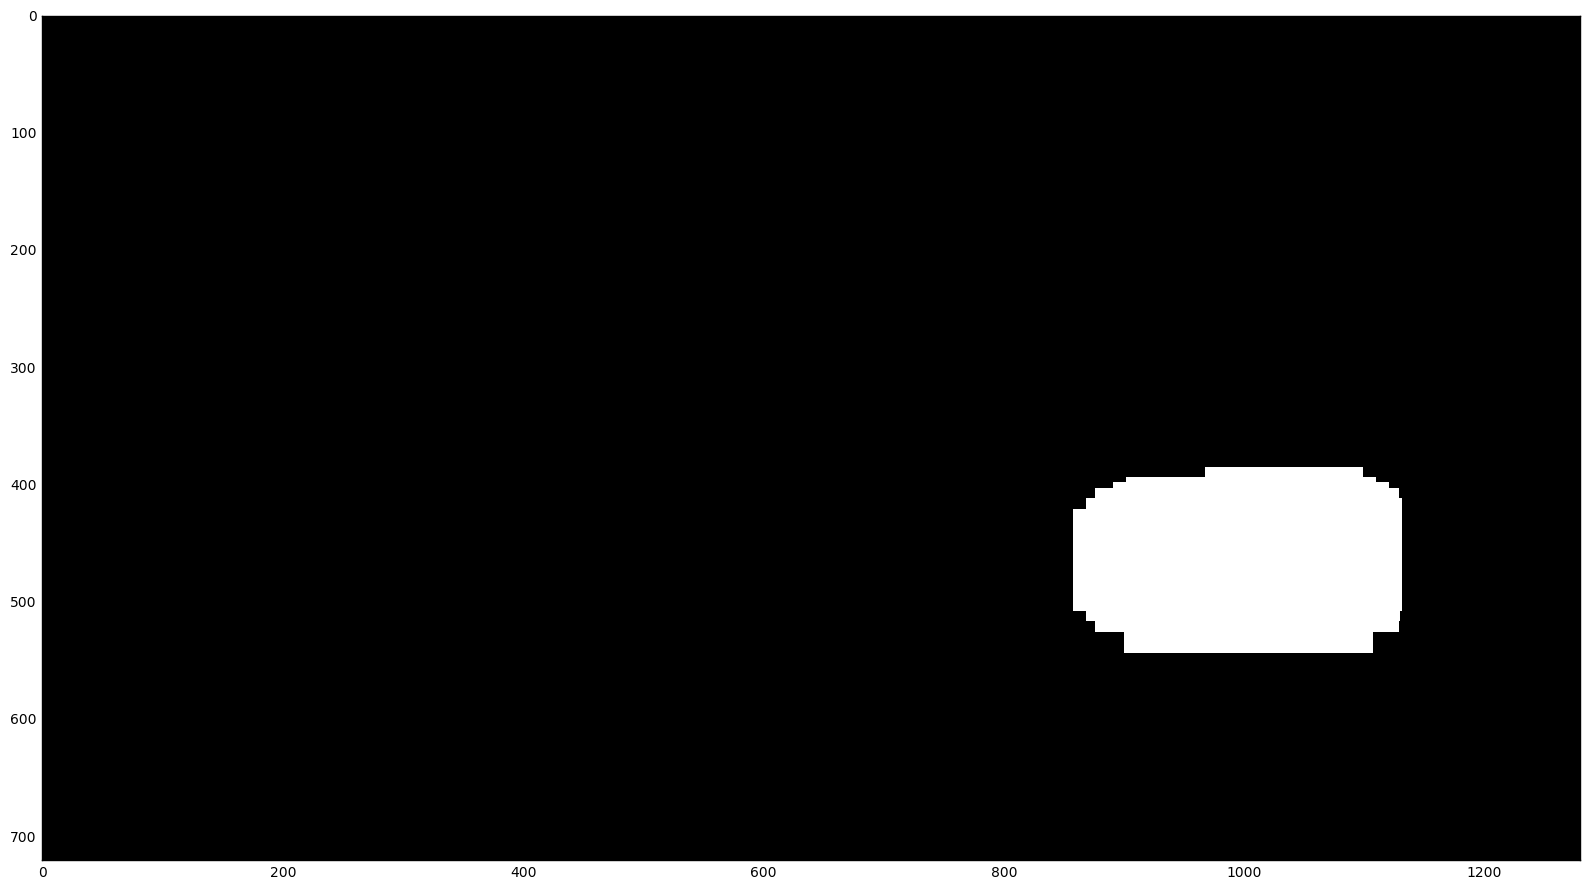

3.08 Seconds to search and locate 113 windows...
1 cars found


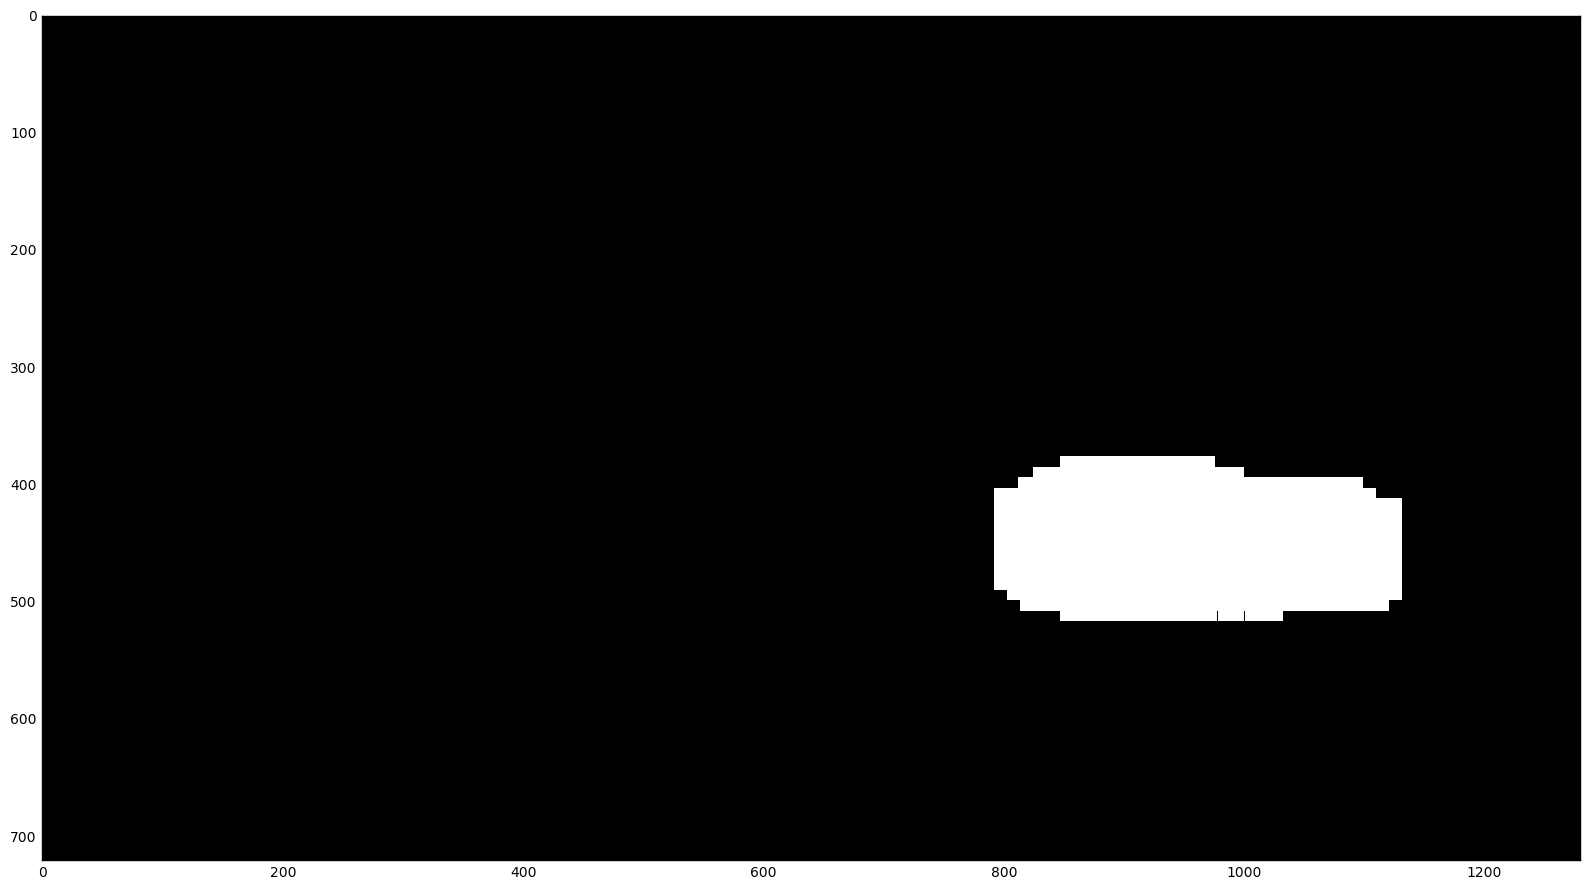

In [18]:
images = glob.glob('output_images/project_video/*_IN.jpg')
vehicle_detection_op.vis_detections = False
vehicle_detection_op.vis_labels = True
vehicle_detection_op.vis_heat = False
for img_path in images:
    result = pipeline.process_image(mpimg.imread(img_path))

### Here the resulting bounding boxes are drawn onto the last frame in the series:

2.92 Seconds to search and locate 75 windows...
2 cars found


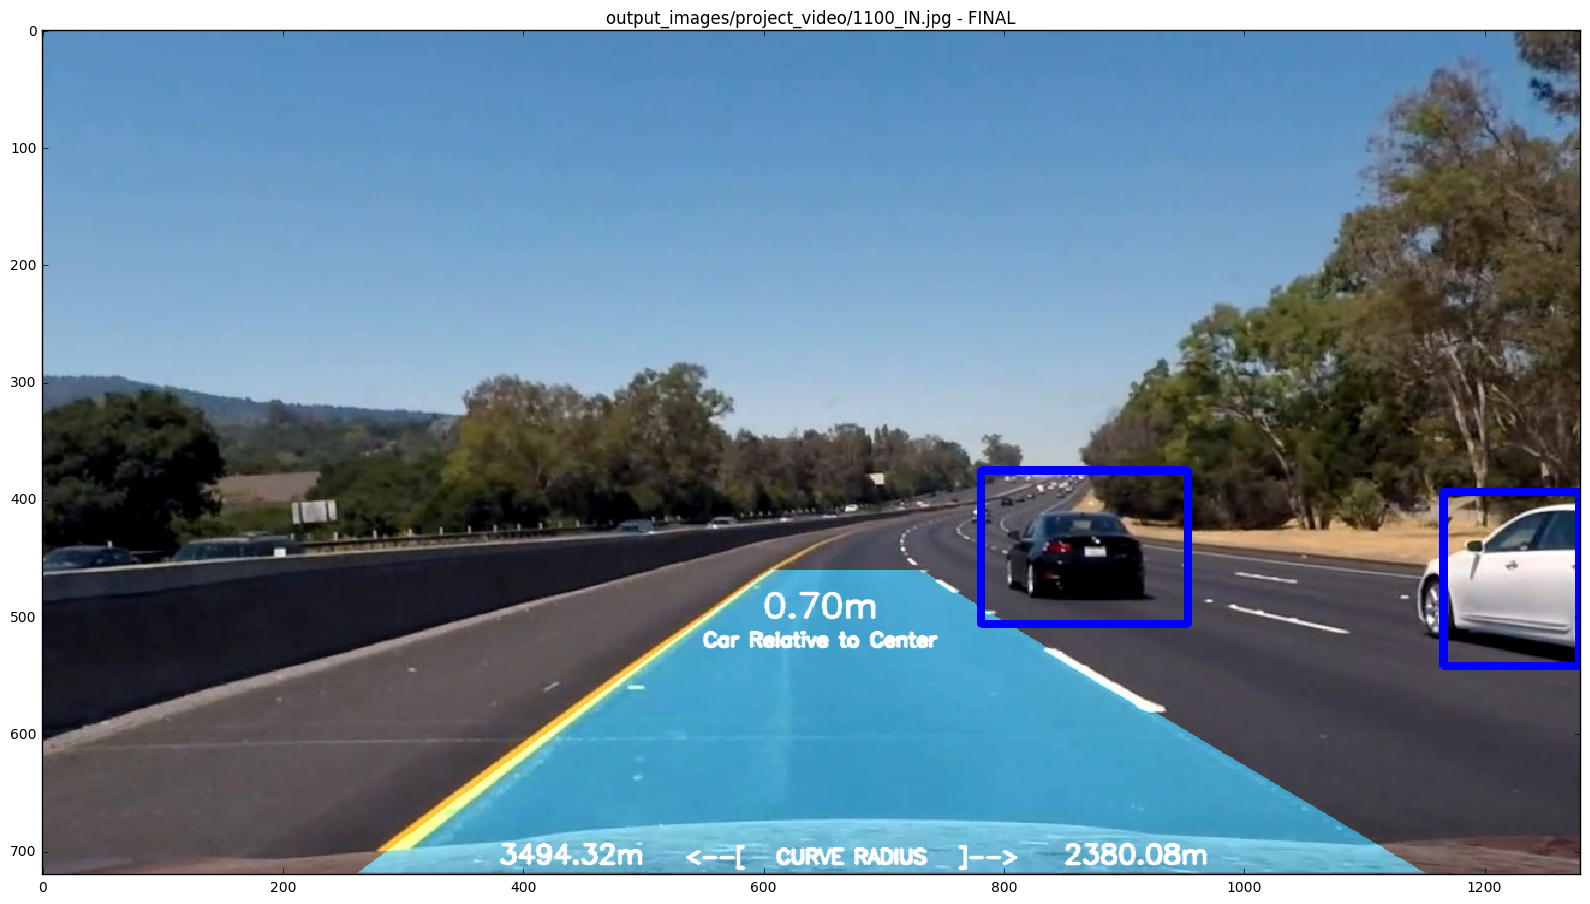

2.92 Seconds to search and locate 37 windows...
1 cars found


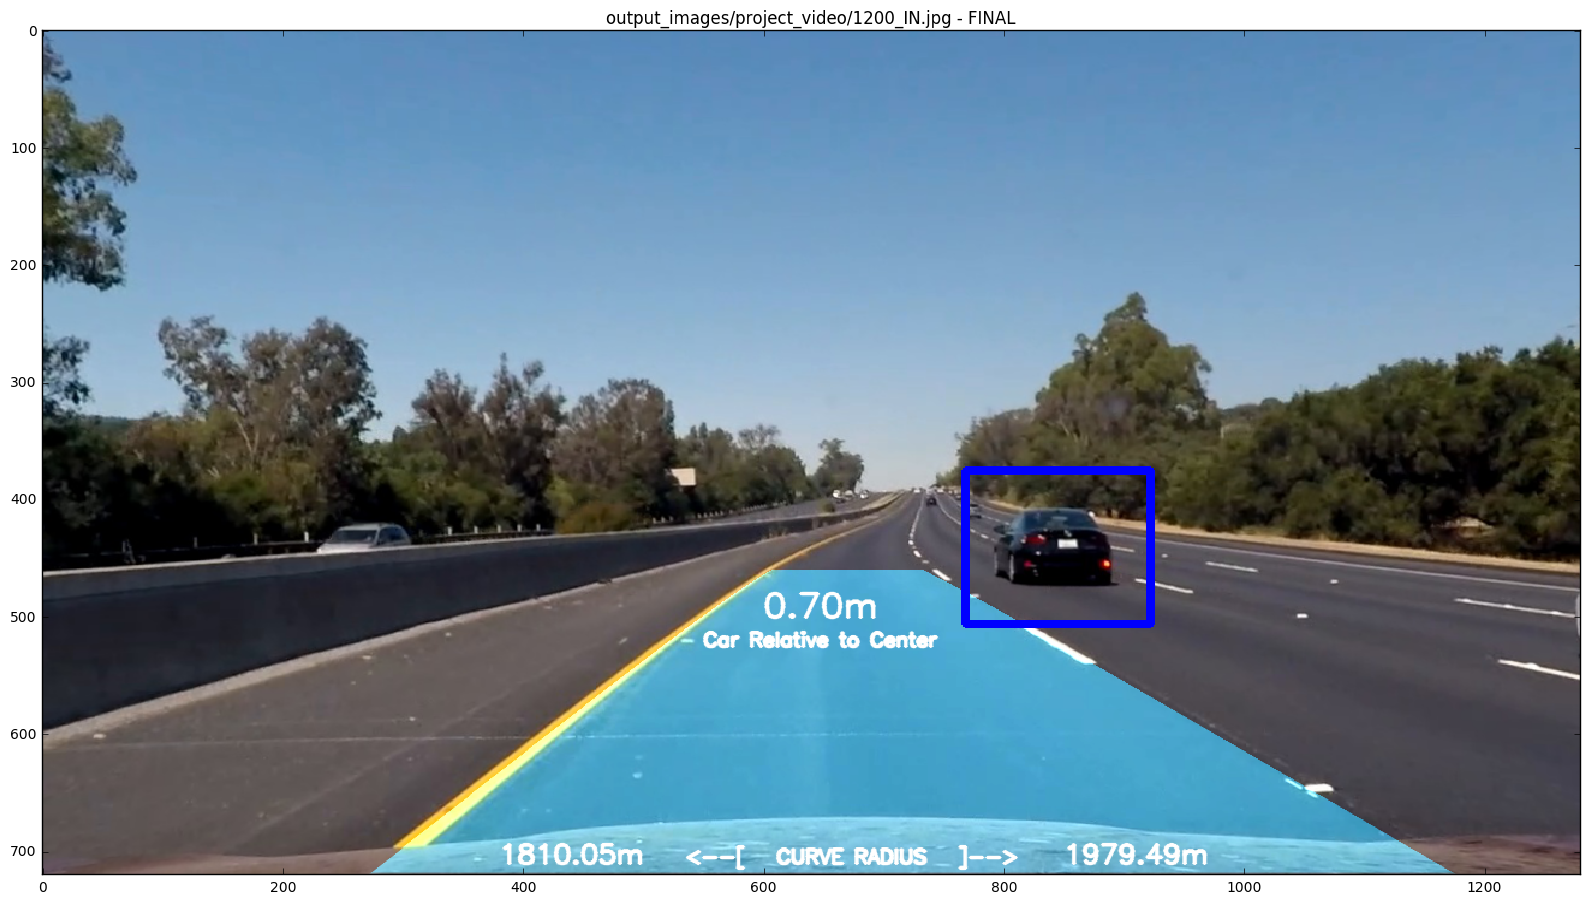

2.87 Seconds to search and locate 96 windows...
2 cars found


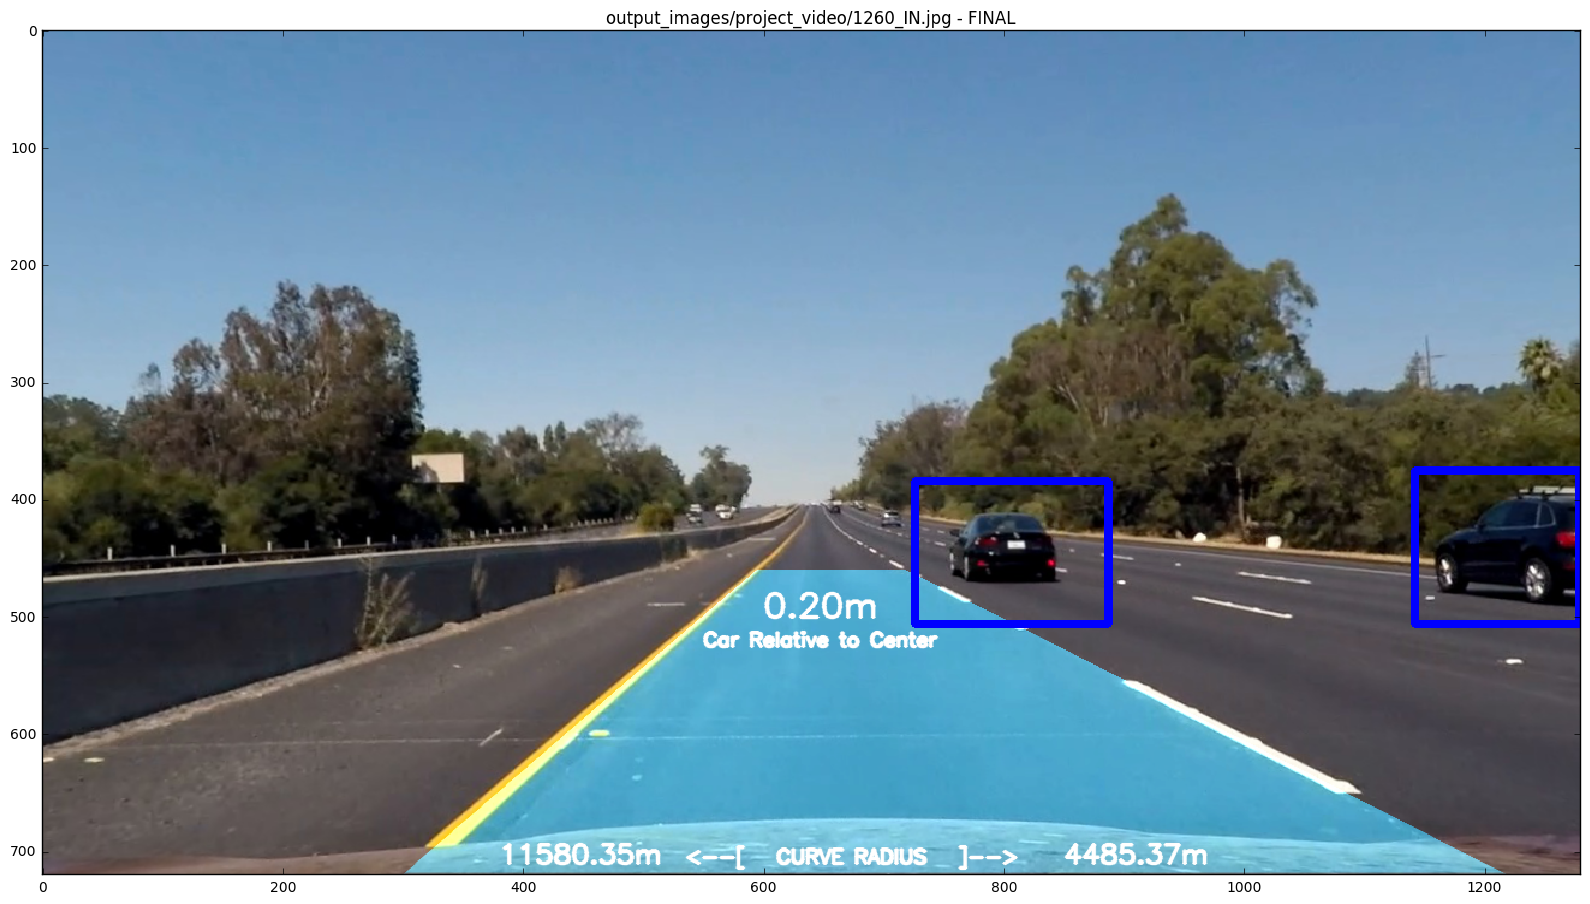

2.87 Seconds to search and locate 49 windows...
1 cars found


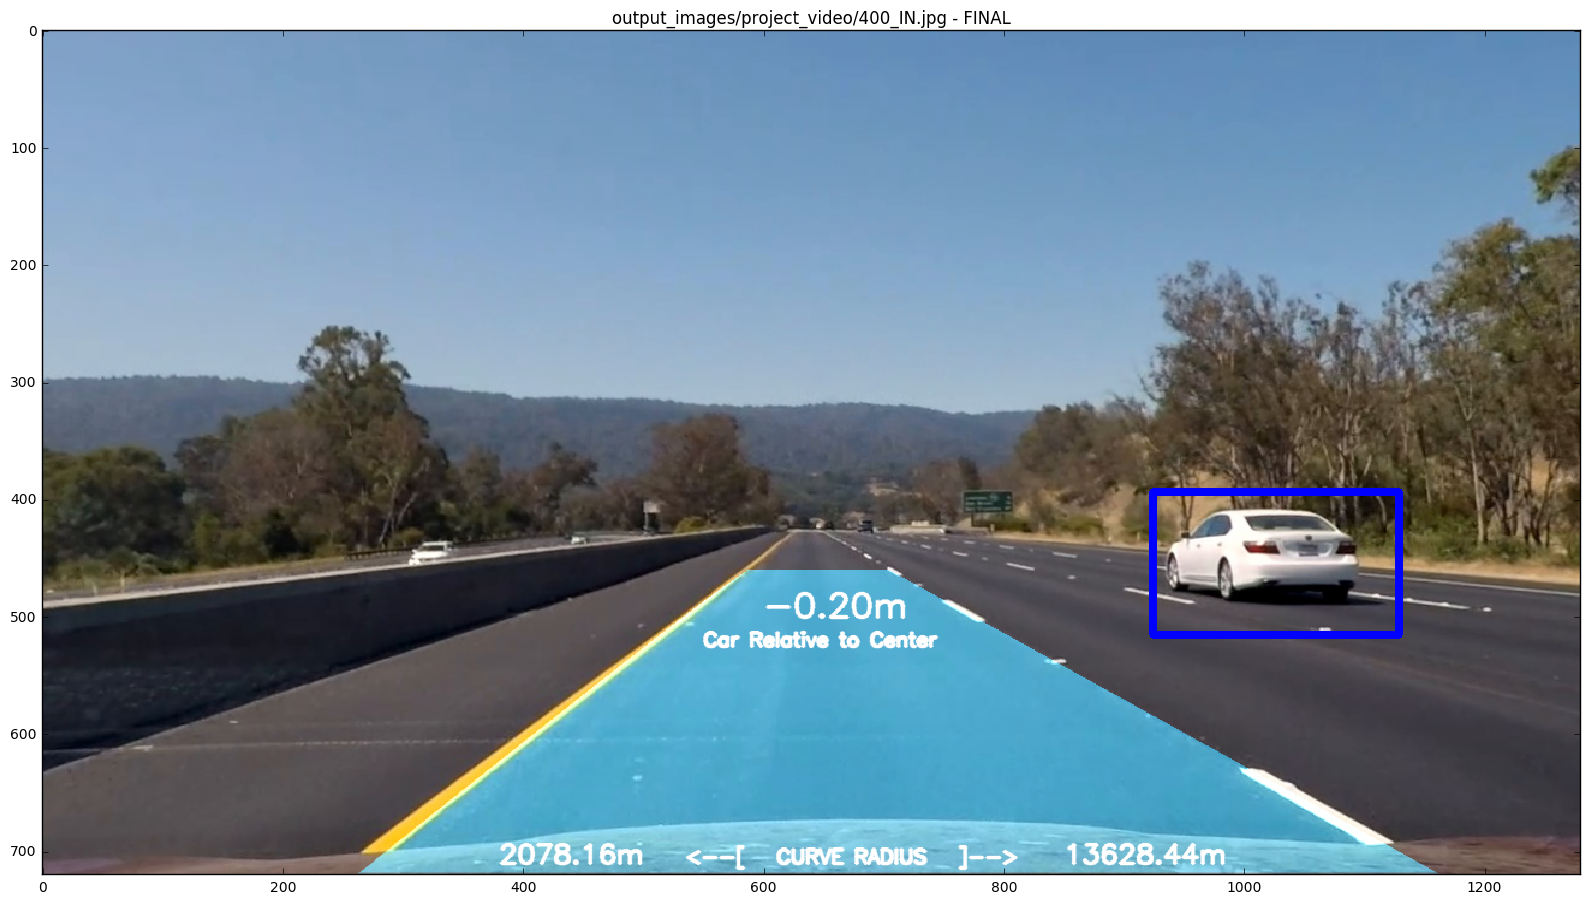

2.69 Seconds to search and locate 34 windows...
1 cars found


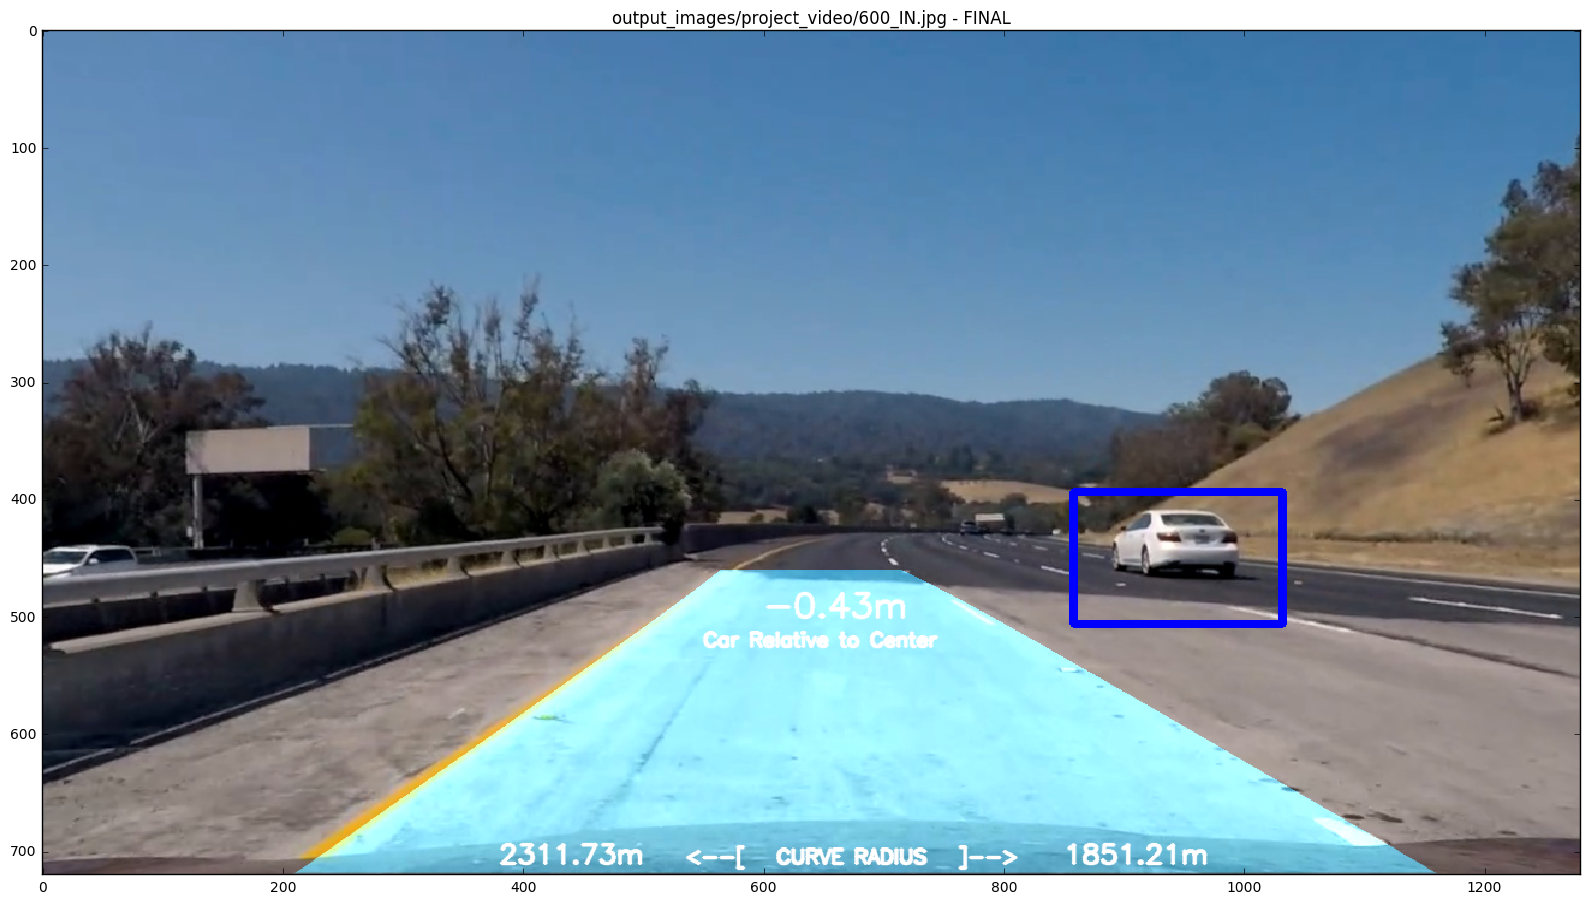

2.93 Seconds to search and locate 89 windows...
1 cars found


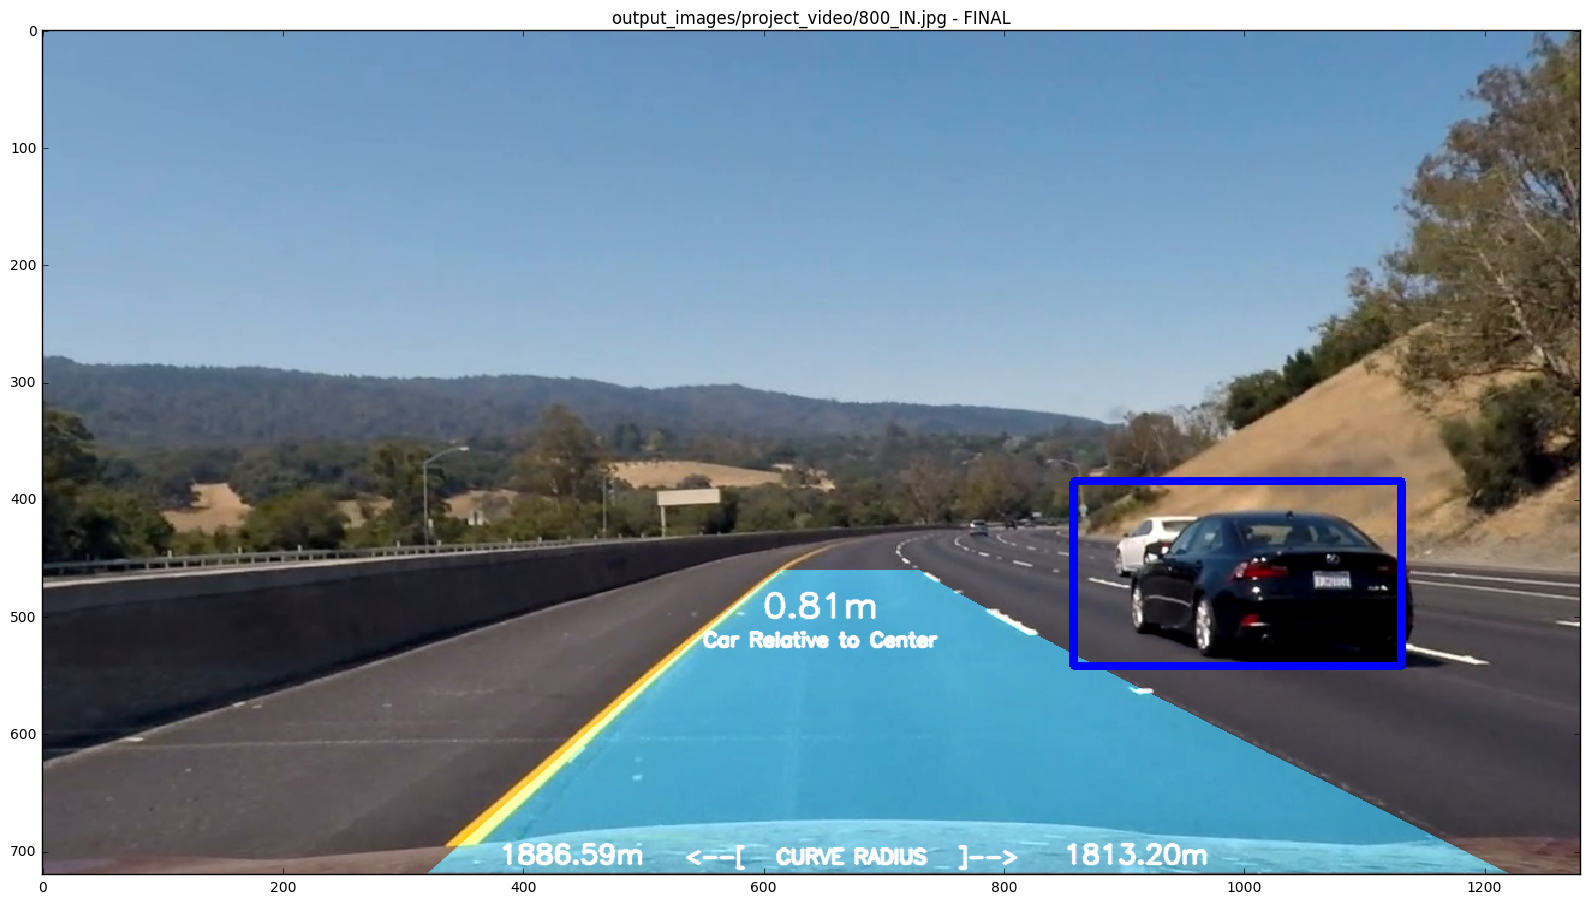

2.89 Seconds to search and locate 113 windows...
1 cars found


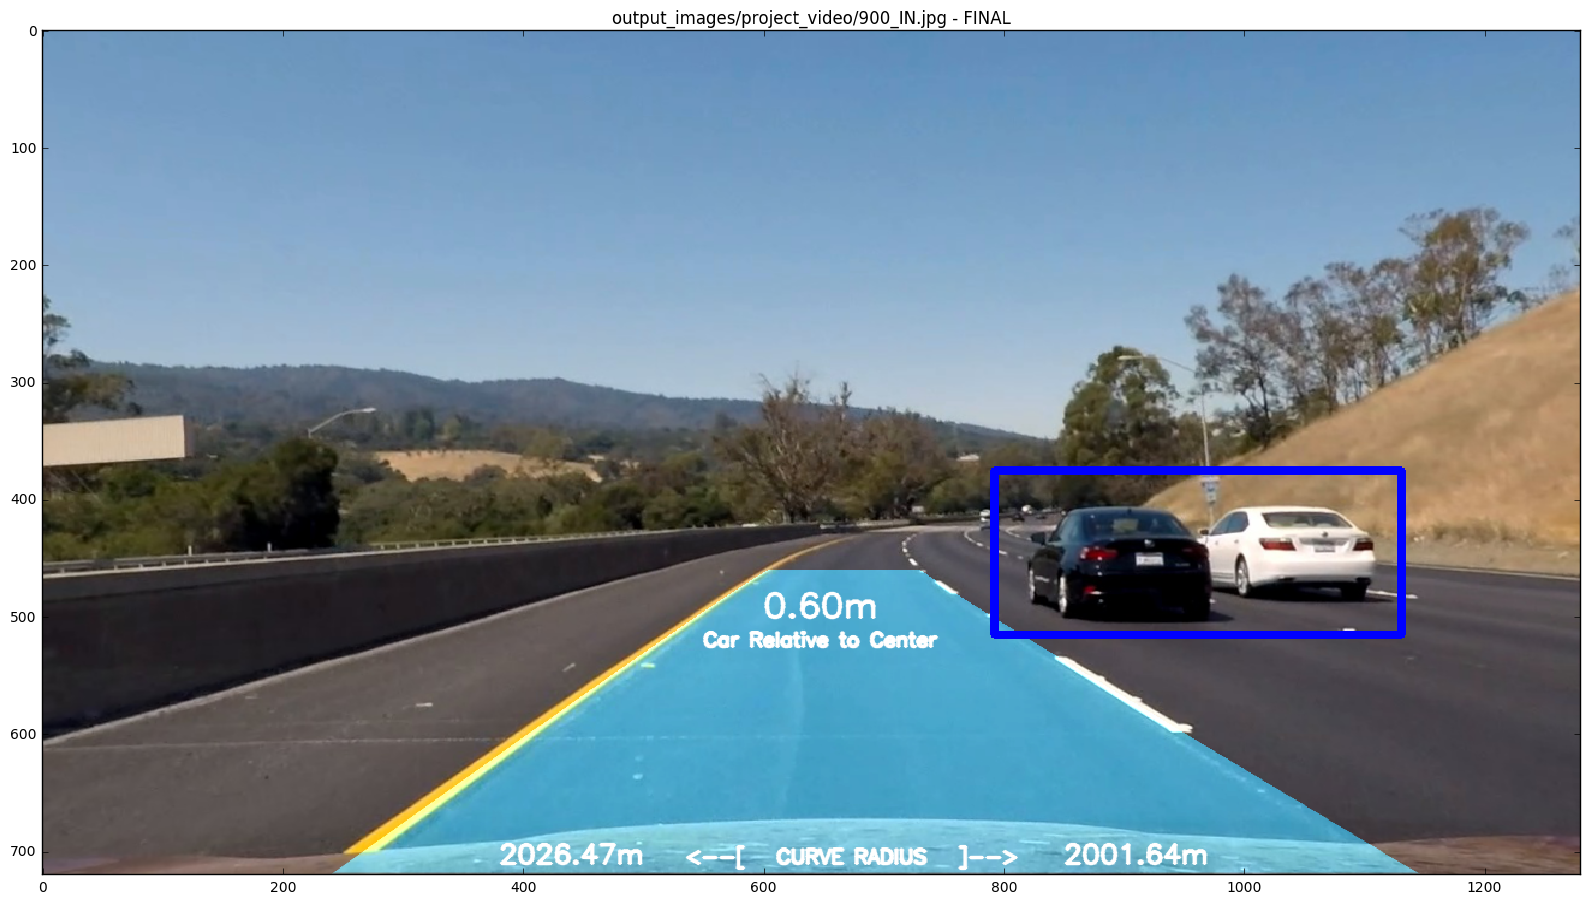

In [19]:
images = glob.glob('output_images/project_video/*_IN.jpg')
vehicle_detection_op.vis_detections = False
vehicle_detection_op.vis_labels = False
vehicle_detection_op.vis_heat = False
for img_path in images:
    result = pipeline.process_image(mpimg.imread(img_path))
    cv2.imwrite('output_images/project_video/{}_FINAL.jpg'.format(os.path.basename(img_path).split('.')[0]), cv2.cvtColor(result, cv2.COLOR_RGB2BGR))
    PlotImageOp(result*255, title="{} - FINAL".format(img_path), cmap=None).perform()

---

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

Here I'll talk about the approach I took, what techniques I used, what worked and why, where the pipeline might fail and how I might improve it if I were going to pursue this project further. 


---

The greatest challenge I faced during this process was minimizing processing time for each detection operation. As it stands with my current pipeline settings, I ultimately langed on a overlap value 0.9 because it resulted in the most accurate number of predictions across all frames. There are still a few frames which didn't make my `5` window threshold so no bounding box was drawn over the vehicle and I did see one or two anomolies creep into the video.

To make it more robust, I would track detected objects and smooth out the window over time using clever moving average algoithms for a cleaner detection experience. I would also implemented a "Left Lane Window Sliding", "Center Lane Window Sliding" and "Right Lane Window Sliding" modes which I'd use to adjust the windows in which I search against based on the lane I am in. I would brake the viewing space up into various sections to filter against and I'd leverage concurrency whereever possible to minimize lag between frames, etc. because in a real-time situation, speed is absolutely critical.